# Pyramids and Resampling

* Note that this is just a brief overview
* This is covered in much more depth in EE 513: Introductory Image Processing

In [48]:
import cv2 as cv
import os
import matplotlib.pyplot as plt
import numpy as np
import matplotlib
from scipy import signal
import scipy

plt.rcParams['text.usetex'] = True

In [49]:
def AddColorbar(axes,colorMap='gray'):
    images = axes.get_images()
    if len(images) > 0:
       vmin, vmax = images[0].get_clim()
    sm = matplotlib.cm.ScalarMappable(matplotlib.colors.Normalize(vmin=vmin,vmax=vmax),cmap=colorMap)
    bb = np.array(axes.get_position().bounds)
    bb[0] += bb[2]*0.95
    bb[2] *= 0.05
    
    figure = axes.get_figure()
    barAxes = figure.add_axes(bb)
    figure.colorbar(sm,barAxes)

In [50]:
def GetTestImage(nPixelsPerSide=25):
    iHalf = int(nPixelsPerSide/2)
    i14   = int(nPixelsPerSide*1/4)
    i34   = int(nPixelsPerSide*3/4)
    #image = np.ones((nPixelsPerSide,nPixelsPerSide),np.float32)*0.2
    image = np.zeros((nPixelsPerSide,nPixelsPerSide),np.float32)
    image[iHalf,:] = 1.0
    image[:,iHalf] = 1.0
    image[iHalf:,i34] = 1.0
    image[i34,iHalf:] = 1.0
    image[i14,i34] = 1.0
    image[i34:,iHalf:i34] = 1.0
    for c in range(iHalf): 
        image[c,c] = 1.0
        image[-1-c,c] = 1.0
    return(image)

In [51]:
def GetImpulseImage(nPixelsPerSide=25):
    iHalf = int(nPixelsPerSide/2)
    image = np.zeros((nPixelsPerSide,nPixelsPerSide),np.float32)
    image[iHalf,iHalf] = 1.0
    return(image)

In [52]:
def GetChirpImage(nPixelsPerSide,fMax=0.4):
    iv = np.arange(nPixelsPerSide) 
    iv = iv.reshape(-1,1)
    irows = iv*np.ones((1,nPixelsPerSide))
    icols = np.transpose(irows)
    image = signal.chirp(irows,0,irows.max(),fMax)*signal.chirp(icols,0,icols.max(),fMax)
    return(image)

# Resampling

* Resampling is the process of changing the resolution of an image
* We often need to change the resolution (number of pixels per side) of an image
* This may involve either increasing or decreasing the number of pixels
* There are many applications of being able to do this
    * Matching the resolution between two different images so they can be compared more easily
    * Reducing computation
* Appropriate resolution may not even be known
* Suppose we want to find a face in an image
* We have no idea if the face is in a small or large part of the image
* The scale is unknown
* Usually this means we have to search at all scales
* The notion of scale isn't often used in signal processing
    * Except for wavelets
    * But then scale is very similar to frequency
* Is very important in image processing and computer vision
    * Scale relates to how far away an object is when the picture is taken (range)
    * Also relates to magnification and zoom
    * In signal processing, we rarely have control of these
* Much more efficient (computationally) to reduce the number of pixels when looking at large scales with large features
* Thus, we need to be able to increase or decrease the size of an image
* Increasing the size of an image is called _interpolation_
* Decreasing the size of an image is called _decimation_
* Once we have this ability we can go up or down in size easily
* If we want to search across different scales, we can create a hierarchy of images at different scales
* Called _image pyramids_

## Interpolation

* Interpolation is done essentially the same way that we interpolate signals
* Recall that if we want to convert a discrete-time signal to a continuous-time signal, the proper way is to use band-limited interpolation
\begin{equation*}
    x(t) = \frac{T_s \omega_c}{\pi}\sum_{n=-\infty}^{\infty} x[n] \mathrm{sinc}\left(\omega_c (t-nT_s)\right)
    \hspace{100em}
\end{equation*}
where $\omega_c$ is the cutoff frequency and $T_s$ is the sampling interval, and
\begin{equation*}
    \mathrm{sinc}(t) = \frac{\sin(\pi t)}{\pi t}
    \hspace{100em}
\end{equation*}

* Note that in the limit you would pick $\omega_c = \frac{2\pi}{T_s}$.

* However, we don't have to use a sinc function
* The sinc function is the only correct function from the standpoint of reconstructing the original signal
* But other functions are possible and are used in image processing

## Upsampling

* Often we will be upsampling by an integer amount
* Most often, this will be by a factor of 2
* There is nothing to prevent us from resampling at any points we like 
* But things get a bit easier when you upsample by an integer amount
* And ultimately our resulting upsampled image has to have an integer number of evenly-spaced pixels

### Image Upsampling
* Image upsampling is just one dimension upsampling applied to rows and columns separately
* We start by creating an image that is the appropriate size of the new image
* Everything is initialized with values of 0
* We then fill in every $k\text{th}$ row with the values of the original image

### OpenCV pyrUp

* OpenCV uses a function called pyrUp (pyramid upsample)
* How well does it perform?
* What kernel does it use?

#### PyrUp
* Uses a 5 x 5 Kernel
* Roughly Gaussian
* They describe it as Gaussian in the documentation
    * However, it clearly isn't Gaussian 
        * No ripple
    * Seems to be actually a bit better than Gaussian (less ripple in constant regions)
    * It's actually a binomial kernel $k = \begin{bmatrix}1 & 4 & 6 & 4 & 1 \end{bmatrix}$
    * This is a really interesting way to approximate a Gaussian with finite duration
* Non-negative
* Preserves constant regions with minimal ripple
* Visually looks good (subjectively)
* Asymptotically Gaussian as the width of the kernel approaches infinity
* Can only upsample by 2


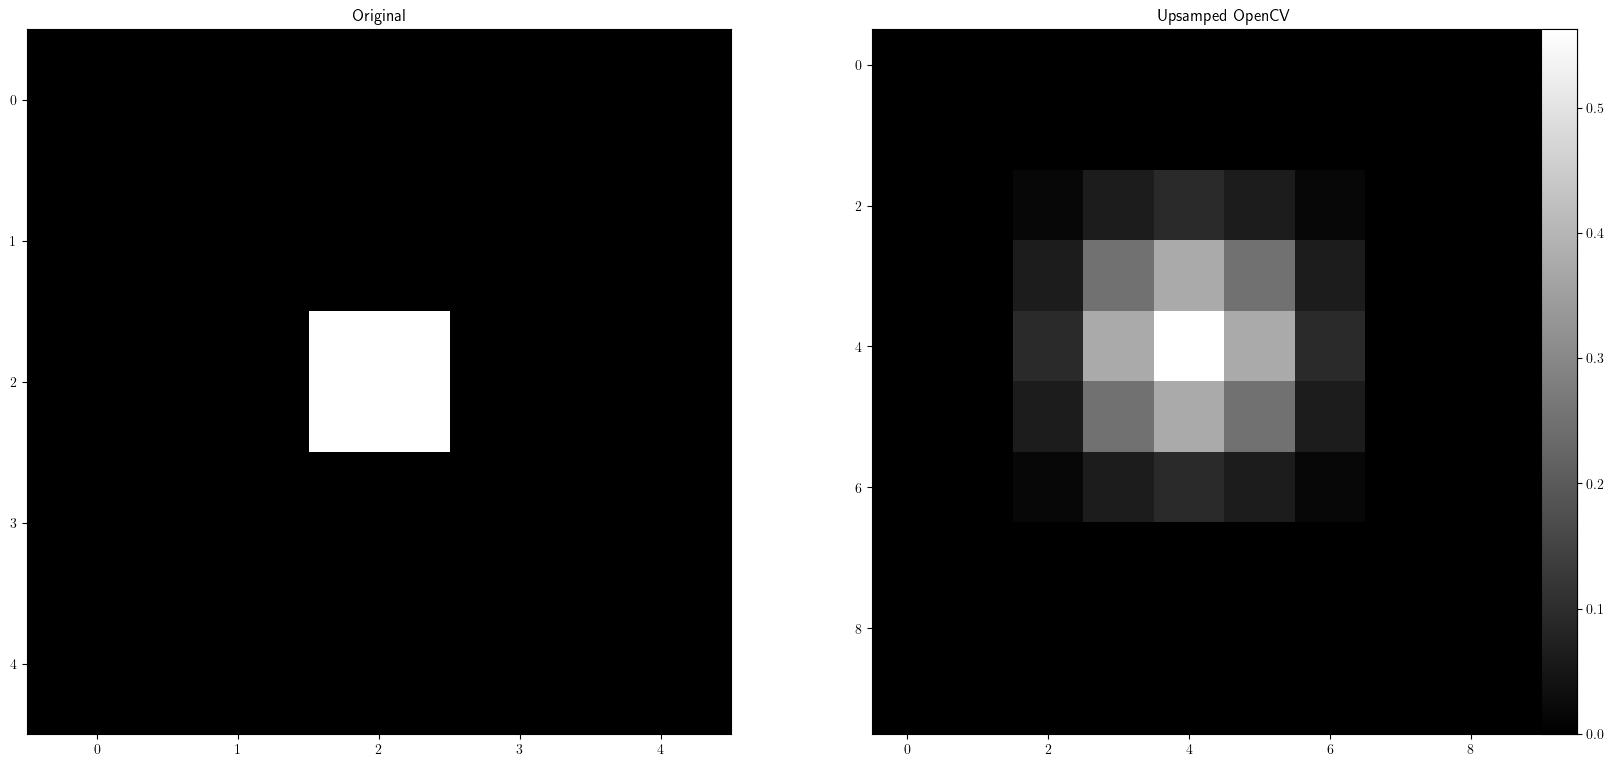

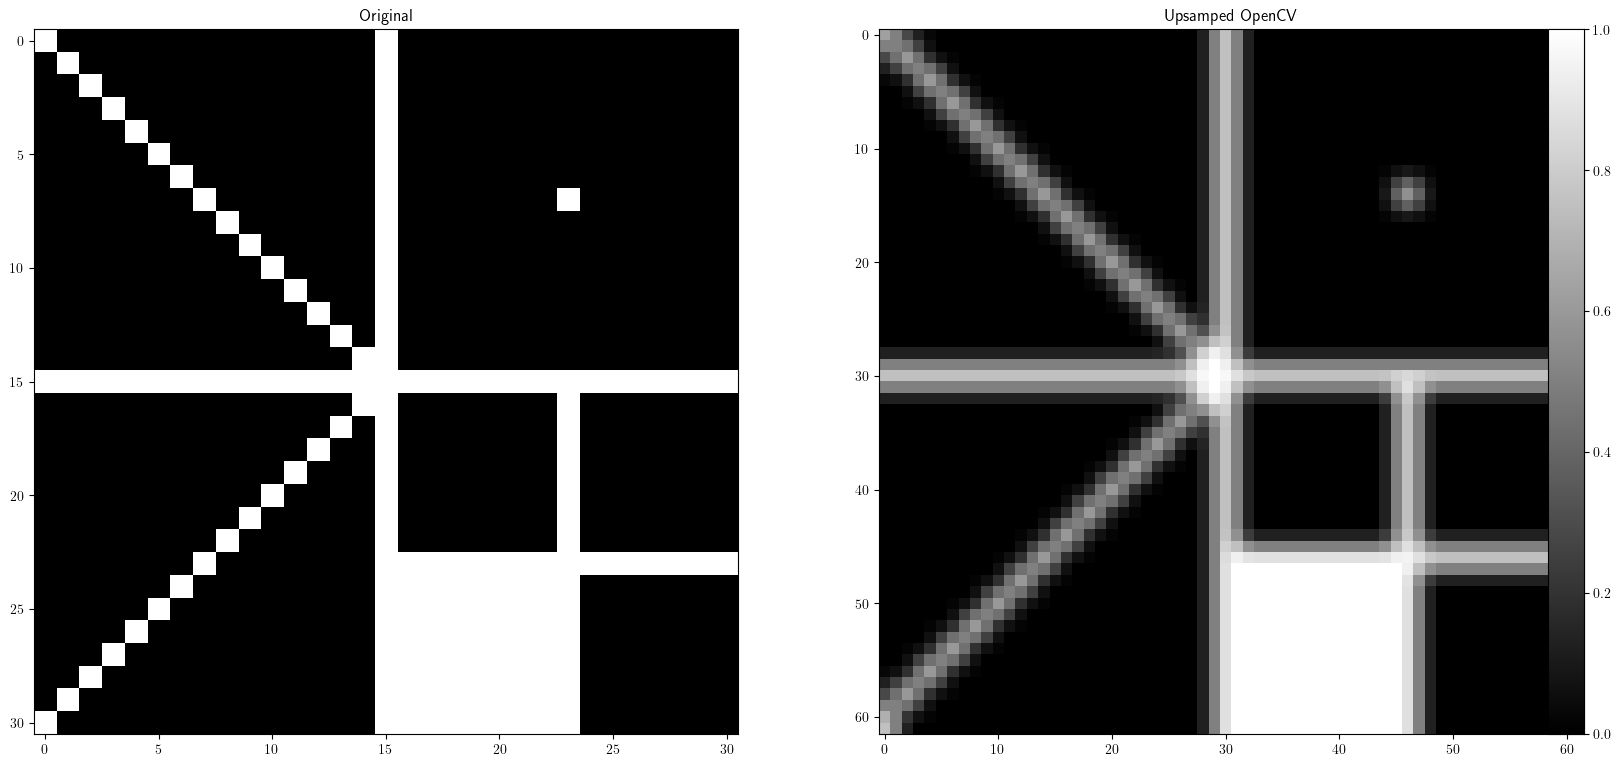

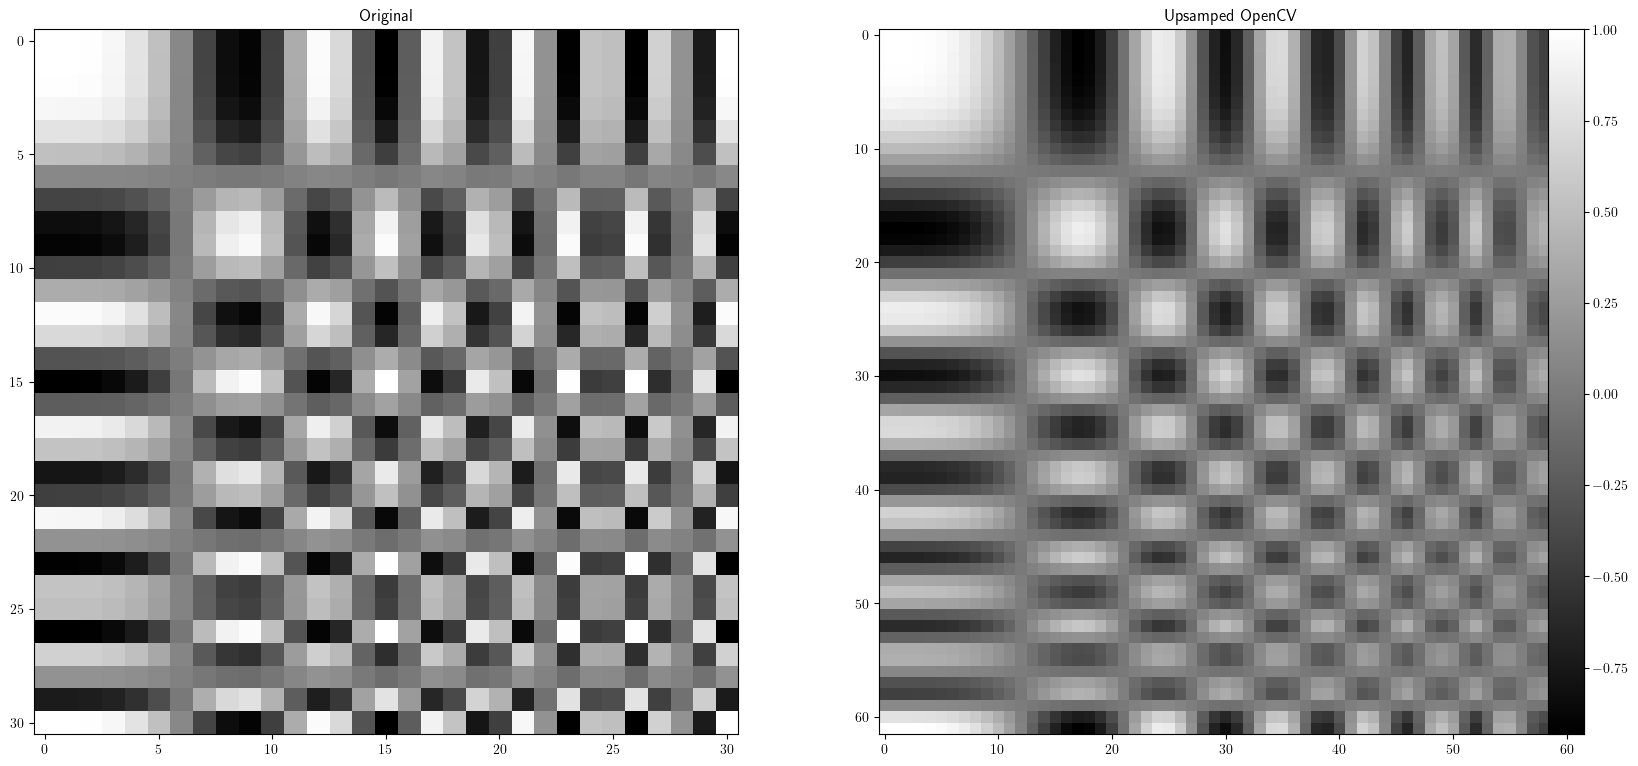

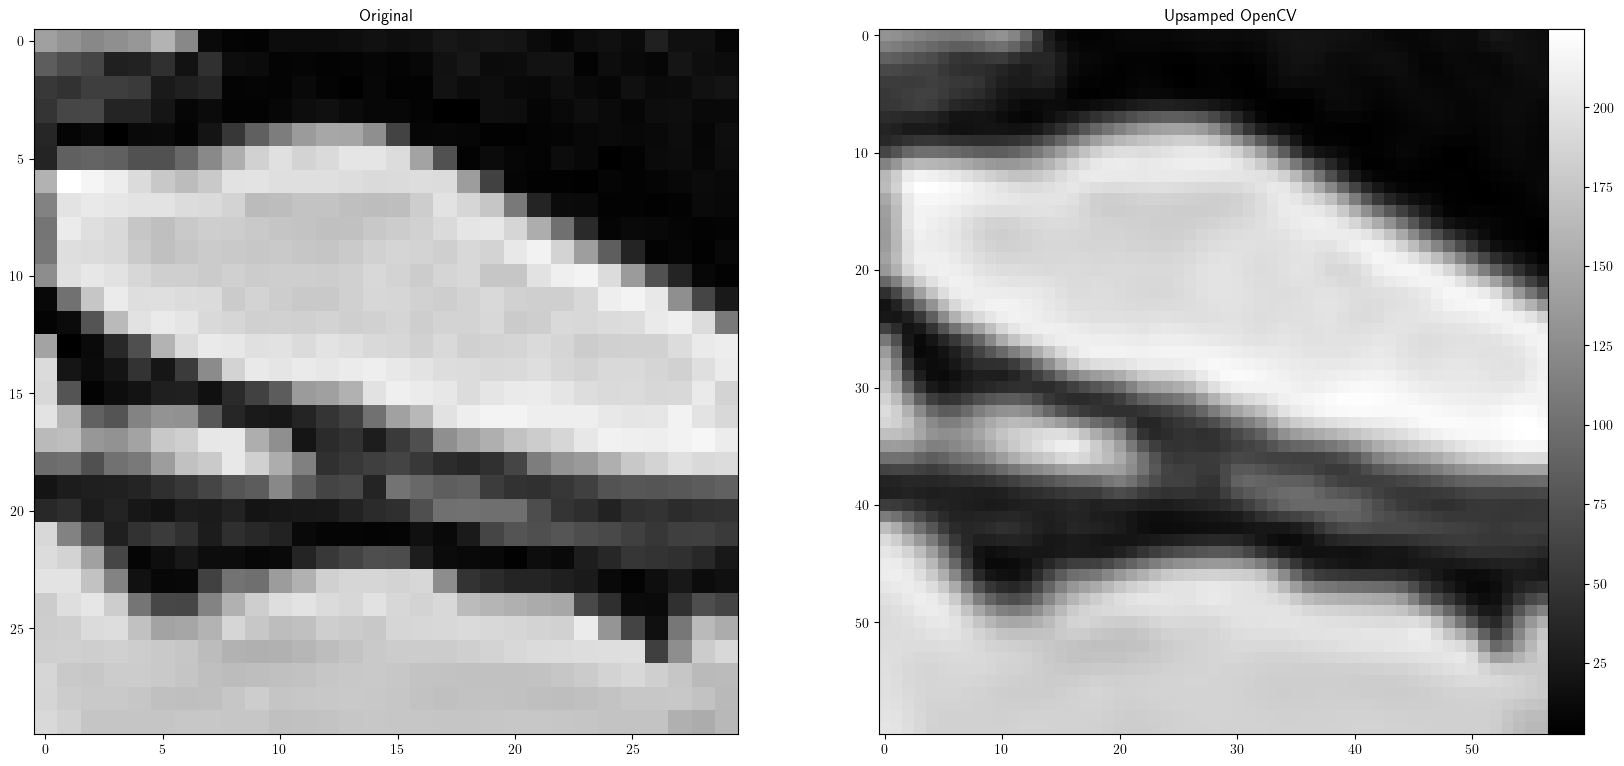

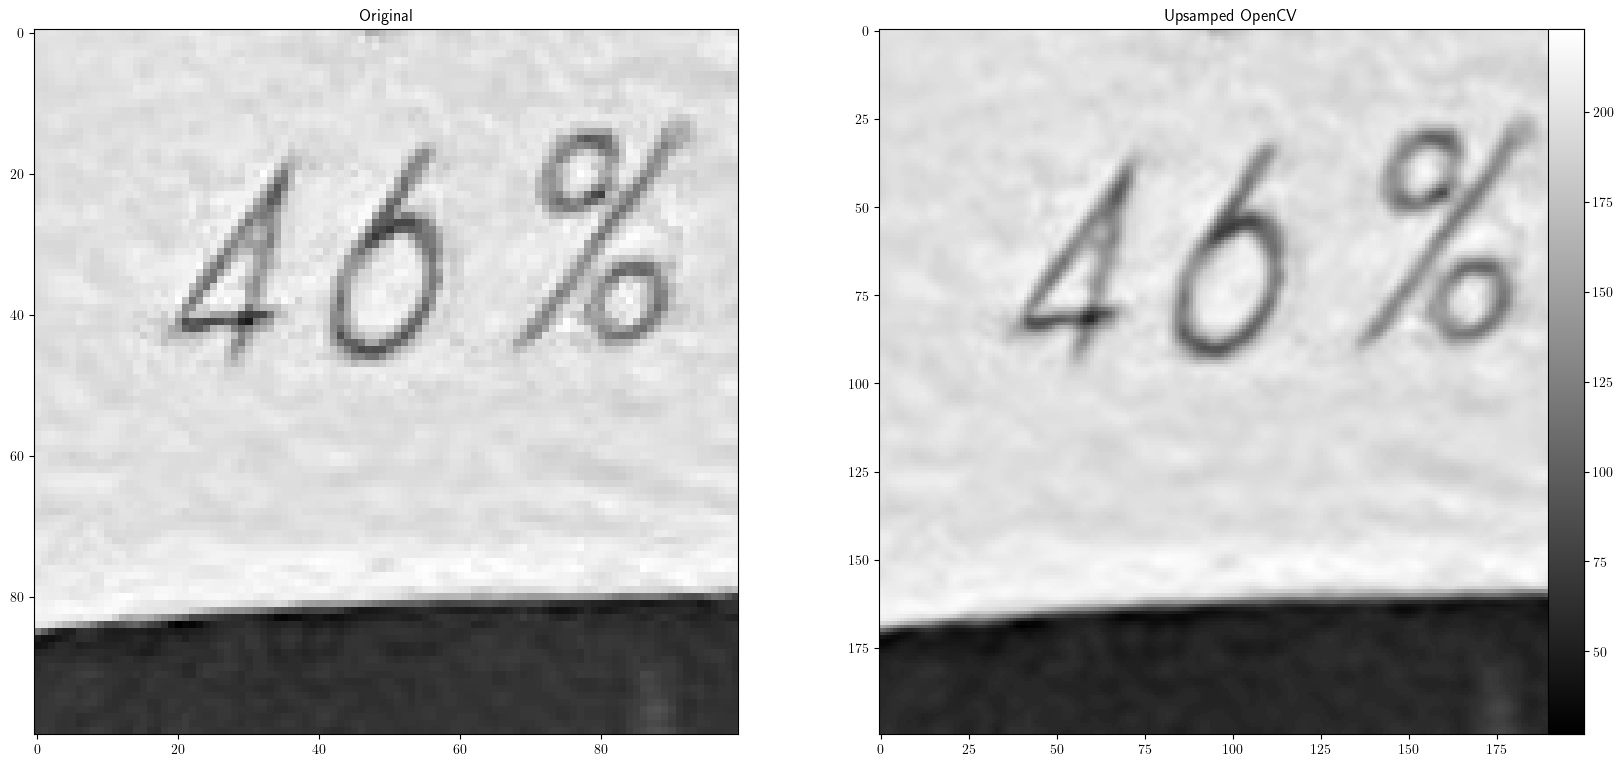

In [53]:
upsampleRate = 2

for cImage in range(5):
    if cImage==0:
        image = GetImpulseImage(nPixelsPerSide=5)
    elif cImage==1:
        image = GetTestImage(nPixelsPerSide=31)
    elif cImage==2:
        image = GetChirpImage(nPixelsPerSide=31)        
    elif cImage==3:
        image = cv.imread('images/DarkTree.jpeg',cv.IMREAD_GRAYSCALE)
        image = image[190:220,190:220].astype('float')
    else:
        image = cv.imread('images/Bourbon.jpeg',cv.IMREAD_GRAYSCALE)
        image = image[1100:1200,730:830]
        
    upsampledCV = cv.pyrUp(image,dstsize=(int(upsampleRate*image.shape[1]),int(upsampleRate*image.shape[0])))        
    
    figure = plt.figure()
    figure.set_size_inches(20,10)
    figure.clf()
    
    axes = figure.add_subplot(1,2,1)
    axes.imshow(image,cmap='gray')
    axes.set_title('Original')

    axes = figure.add_subplot(1,2,2)
    axes.imshow(upsampledCV,cmap='gray')
    axes.set_title('Upsamped OpenCV')
    AddColorbar(axes)
    
    plt.show()

## Downsampling
* We know that if we just sample the image we'll have aliasing

### Aliasing
* Aliasing is something I expect you are familiar with from when you studied sampling
* The sampling theorem indicates that frequencies above 0.5 cycles/pixel will be indistinguishable from lower frequencies
* When this occurs, the image content at high frequencies is said to be aliased down to lower frequencies

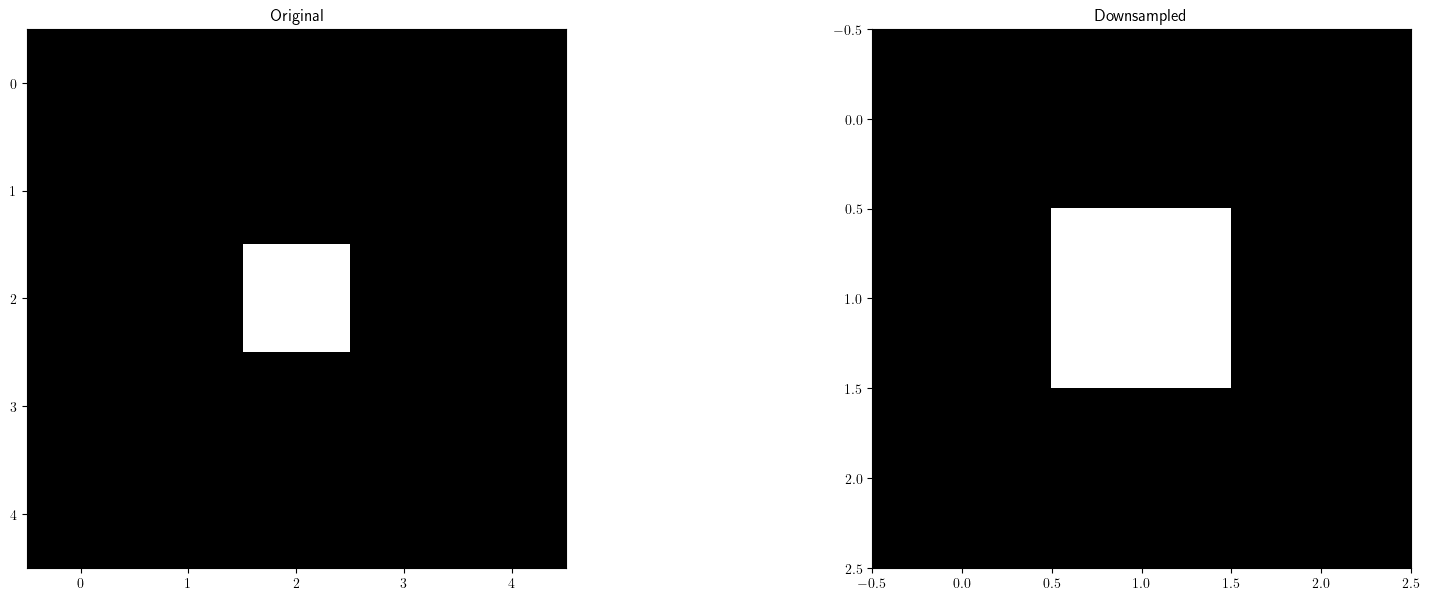

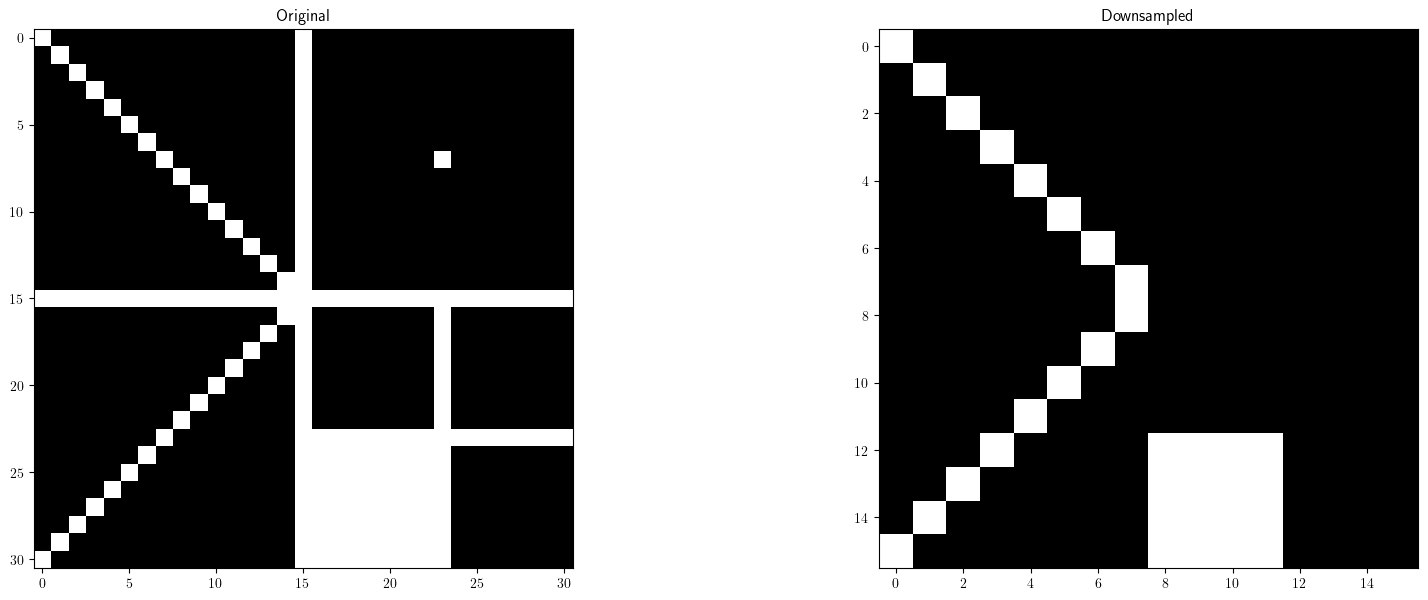

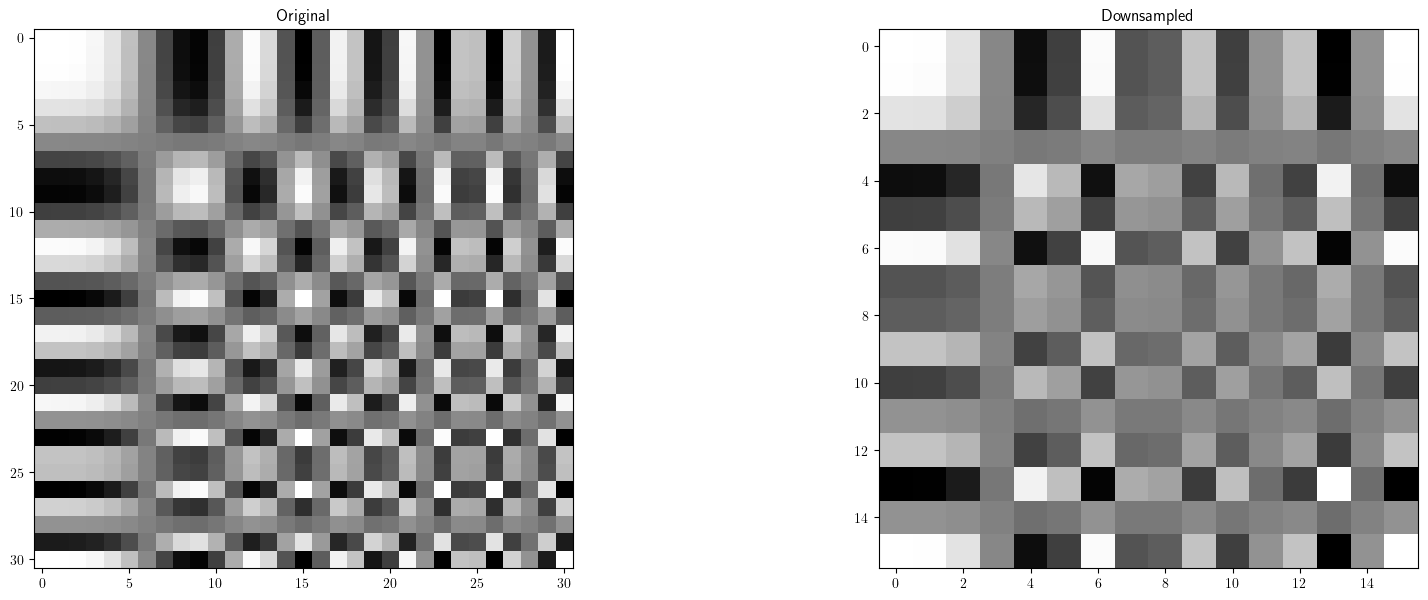

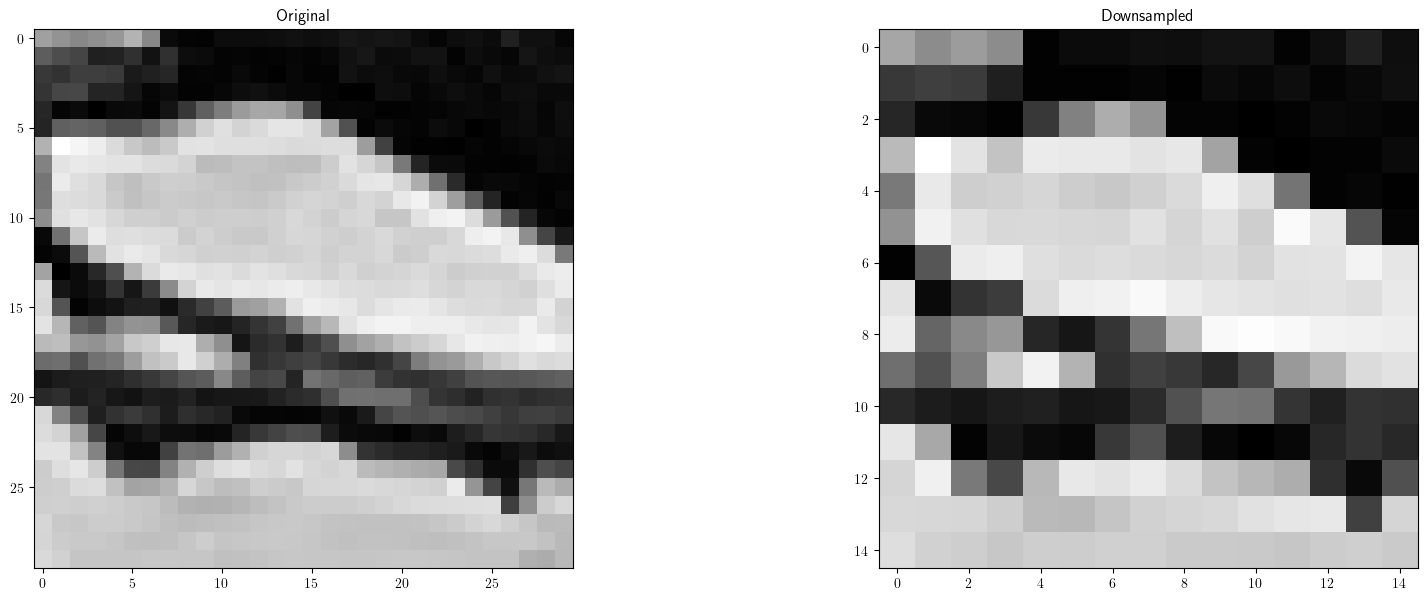

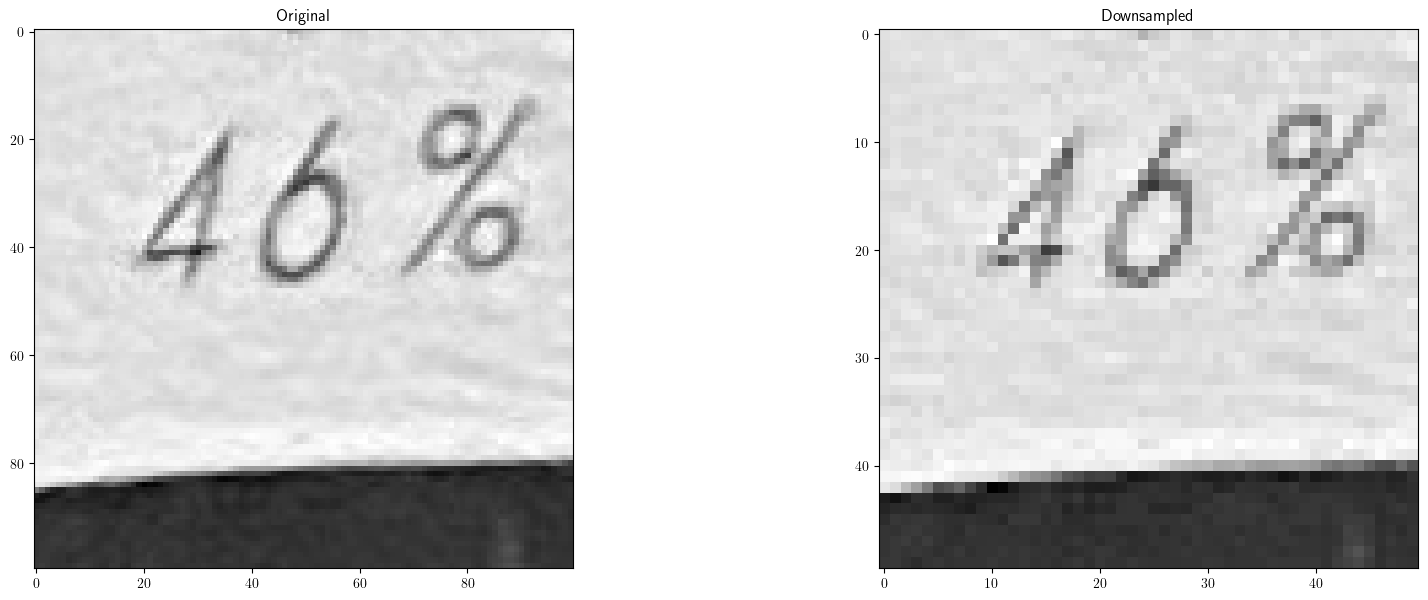

In [54]:
downsampleRate = 2

for cImage in range(5):
    if cImage==0:
        image = GetImpulseImage(nPixelsPerSide=5)
    elif cImage==1:
        image = GetTestImage(nPixelsPerSide=31)
    elif cImage==2:
        image = GetChirpImage(nPixelsPerSide=31)        
    elif cImage==3:
        image = cv.imread('images/DarkTree.jpeg',cv.IMREAD_GRAYSCALE)
        image = image[190:220,190:220].astype('float')
    else:
        image = cv.imread('images/Bourbon.jpeg',cv.IMREAD_GRAYSCALE)
        image = image[1100:1200,730:830]

    downsampled = image[::downsampleRate,::downsampleRate]
        
    figure = plt.figure()
    figure.set_size_inches(20,7)
    figure.clf()
    
    axes = figure.add_subplot(1,2,1)
    axes.imshow(image,cmap='gray')
    axes.set_title('Original')

    axes = figure.add_subplot(1,2,2)
    axes.imshow(downsampled,cmap='gray')
    axes.set_title('Downsampled')

    plt.show()

### Anti-aliasing

* To prevent aliasing, we merely need to apply a lowpass filter with a cutoff frequency of 0.25 cycles/pixel
* However, we have the usual design tradeoffs
    * We do not want the image to be shifted after filtering, so we want the filter to have an even impulse response
    * We want it to be computationally efficient, so we want FIR filters that are as short as possible
    * We do not want oscillations in uniform regions, so we want to minimize oscillations (ringing) 
    * We do not want aliasing, so we want a sharp transition from the passband to the stopband
* These design goals are very similar to those for upsampling

In [55]:
def SymmetricKernelDTFT(kernel):
    kernelSize = len(kernel)
    omega = np.linspace(0,np.pi,500)
    ns = np.arange(-(kernelSize-1)/2,(kernelSize-1)/2+1)
    H = np.zeros_like(omega)
    
    offset = int((kernelSize-1)/2)
    for n in ns:
        H = H + kernel[int(n)+offset]*np.cos(omega*n)
    return omega,H

In [56]:
def GetAntialiasingKernel(kernelName=None):
    kernels = dict()

    nh = 109 # The larger this is, the sharper the frequency response but the greater the computation and edge effects

    # The following are one sided impulse responses for the non-negative delays/offsets only
    # See Table 3.4, Page 131, in Szeliski's Computer Vision, Version 1 
    kernels['Impulse'      ] = np.array([1.0]) # This doesn't filter at all
    kernels['Linear'       ] = np.array([0.50,0.25])
    kernels['Binomial'     ] = np.array([0.375,0.25,0.0625])
    kernels['Cubic'        ] = np.array([0.5,0.28125,0,-0.03125])
    kernels['Windowed Sinc'] = np.array([0.4939,0.2684,0,-0.0153])
    kernels['QMF-9'        ] = np.array([0.5638,0.2932,-0.0519,-0.0431,0.0198])
    kernels['JPEG2000'     ] = np.array([0.6029,0.2669,-0.0782,-0.0169,0.0267])
    kernels['Sinc'         ] = np.sinc(0.5*np.arange(0,nh))
    kernels['OpenCV'       ] = np.array([6.0,4.0,1.0])
    
    halfWindow = scipy.signal.windows.get_window('hamming',nh+1)[int((nh+1)/2):]
    kernels['Hamming Sinc'] = np.sinc(0.5*np.arange(0,(nh+1)/2))*halfWindow
    
    if kernelName is None:
        return(list(kernels.keys()))
    
    h  = kernels[kernelName]
    h  = np.concatenate((h[::-1],h[1:])) # Convert into an odd length symmetric impulse response
    h /= h.sum() # Ensure DC gain is 1
    n  = np.arange(-int((len(h)-1)/2),int((len(h)+1)/2))
    return h,n

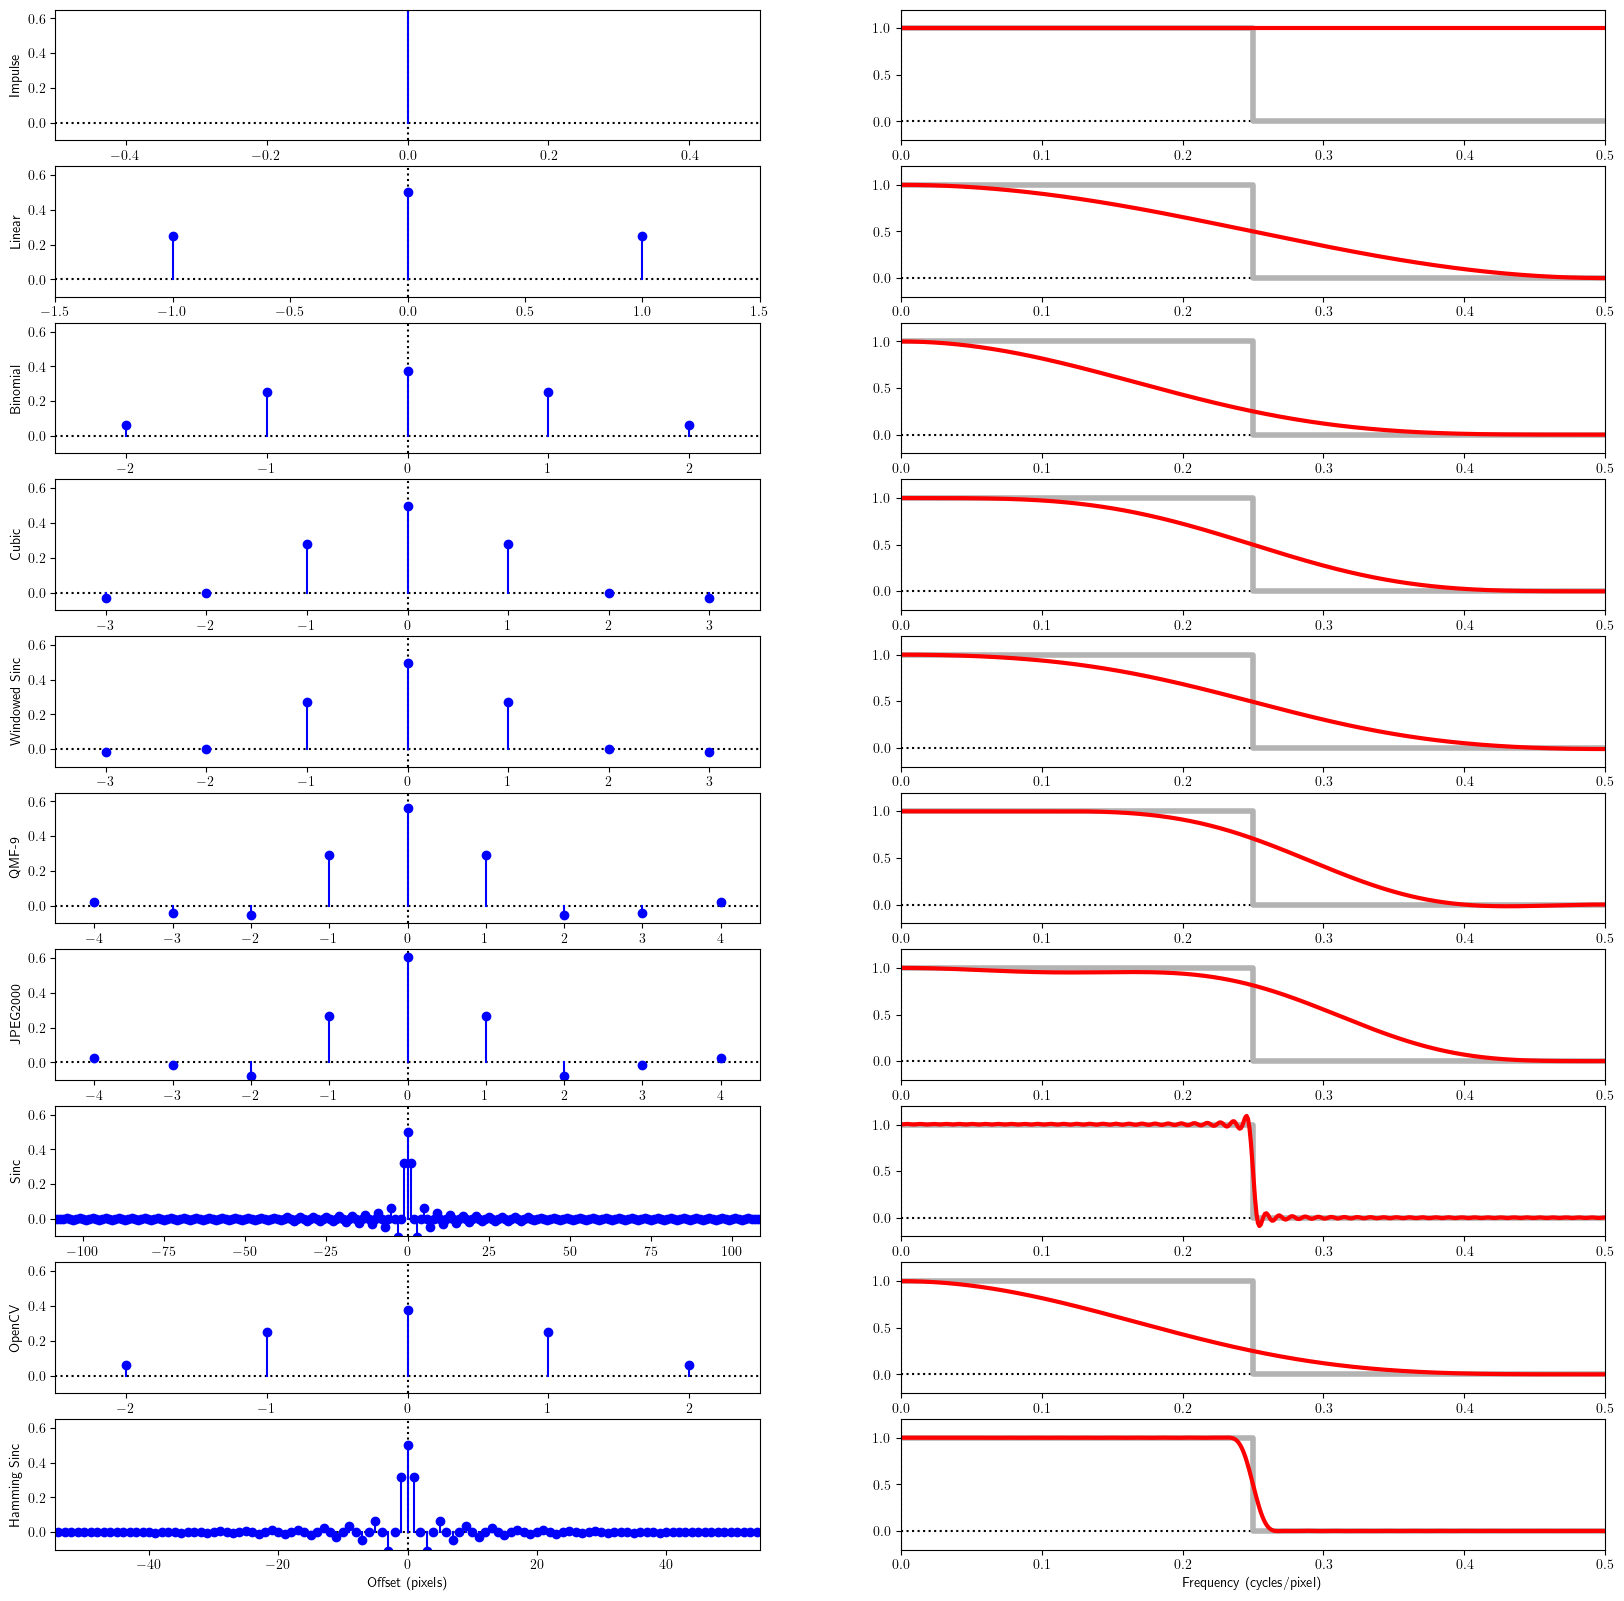

In [57]:
kernelNames = GetAntialiasingKernel()
nKernels = len(kernelNames)

figure = plt.figure()
figure.set_size_inches(20,20)
figure.clf()

for cKernel,kernelName in enumerate(kernelNames):
    h,n = GetAntialiasingKernel(kernelName=kernelName)
    omega,H = SymmetricKernelDTFT(h)    
    
    axes = figure.add_subplot(nKernels,2,cKernel*2+1)
    axes.axhline(0,color='k',linestyle=':')
    axes.axvline(0,color='k',linestyle=':')
    axes.plot(n,h,marker='.',linestyle='none',markersize=12,color='b')
    axes.plot([n,n],[np.zeros_like(h),h],color='b')
    axes.set_xlim([n[0]-0.5,n[-1]+0.5])
    axes.set_ylim([-0.1,0.65])
    axes.set_ylabel(kernelName)
    if kernelName==kernelNames[-1]:
        axes.set_xlabel('Offset (pixels)')
    
    axes = figure.add_subplot(nKernels,2,cKernel*2+2)
    axes.axhline(0,color='k',linestyle=':')
    axes.axvline(0,color='k',linestyle=':')
    axes.plot([0,0.25,0.25,0.5],[1,1,0,0],color=0.7*np.ones(3),linewidth=4.0,label='Ideal AAF')
    axes.plot(omega/(2*np.pi),H,color='r',linewidth=3.0)
    axes.set_xlim([0,0.5])
    axes.set_ylim([-0.20,1.20])
    if kernelName==kernelNames[-1]:
        axes.set_xlabel('Frequency (cycles/pixel)')
    
plt.show()

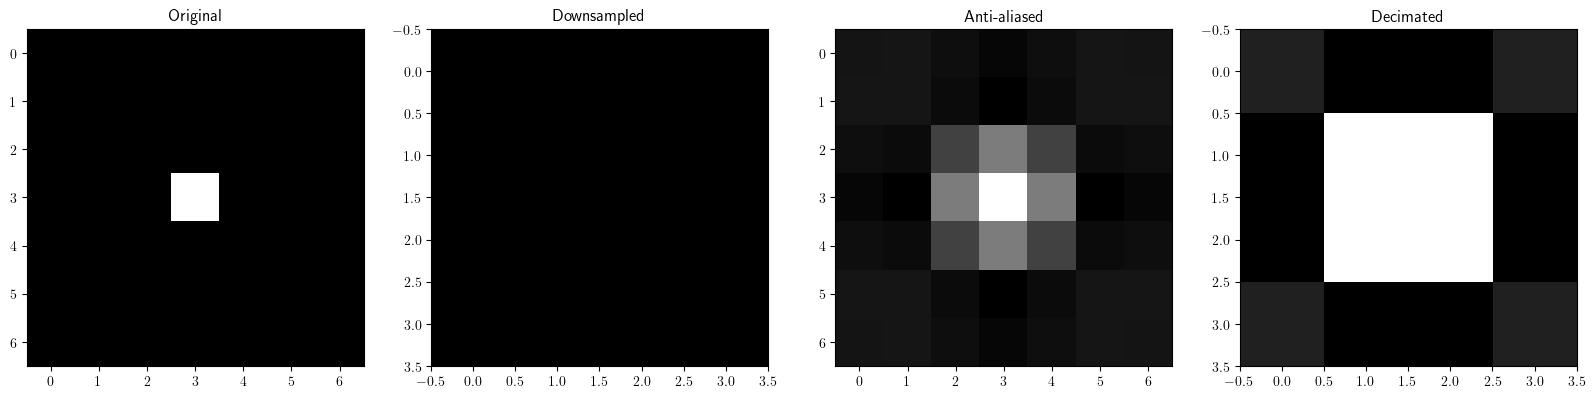

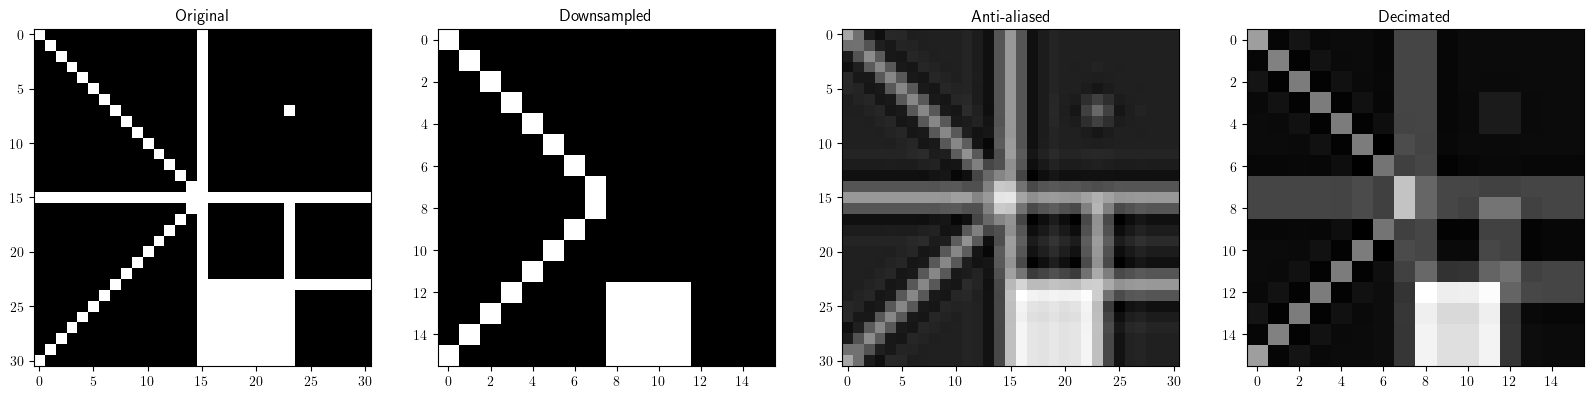

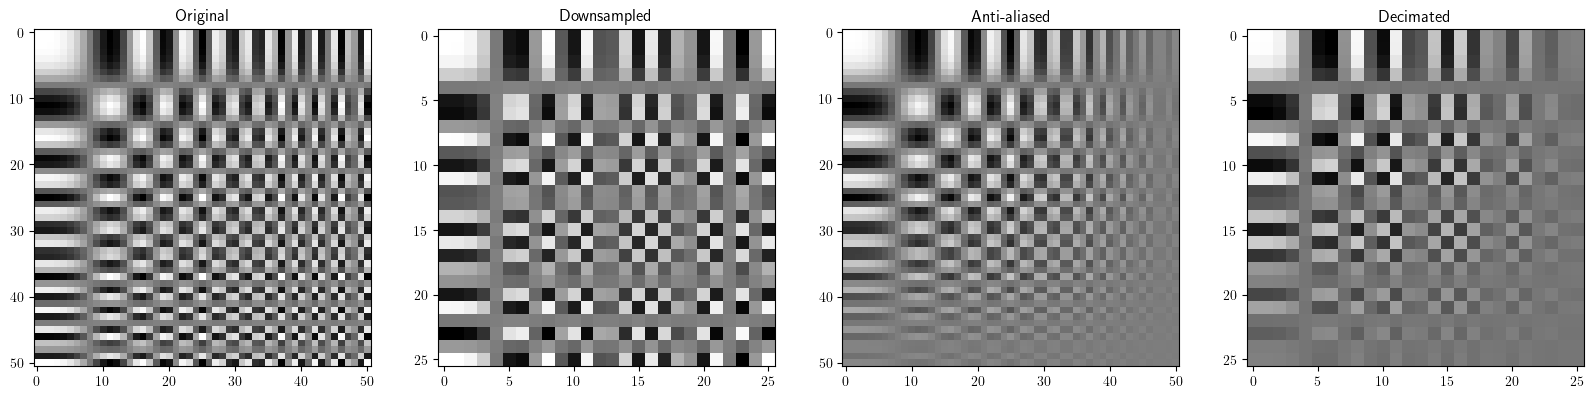

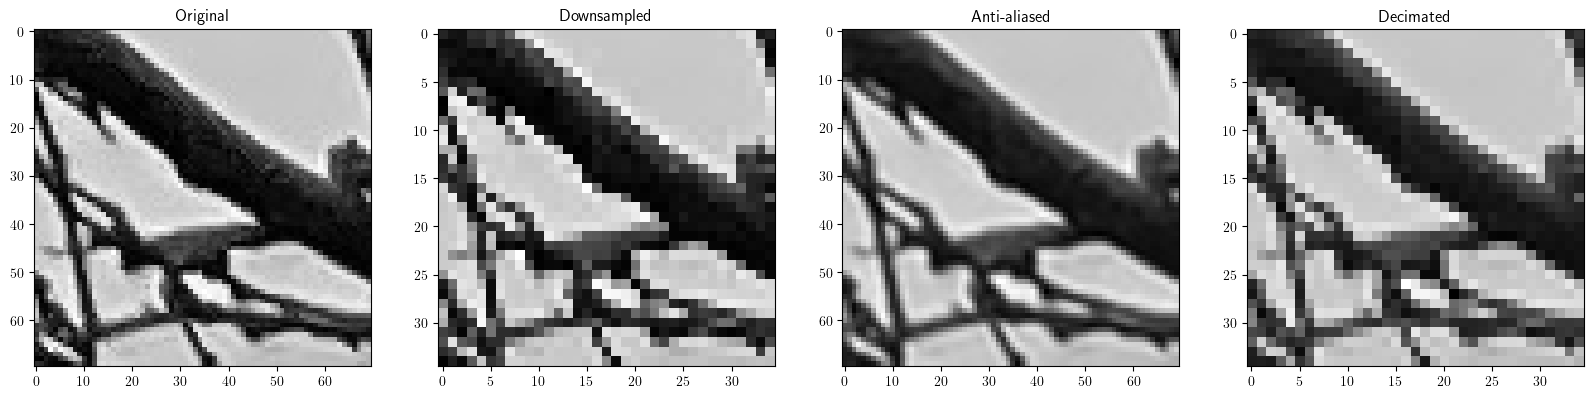

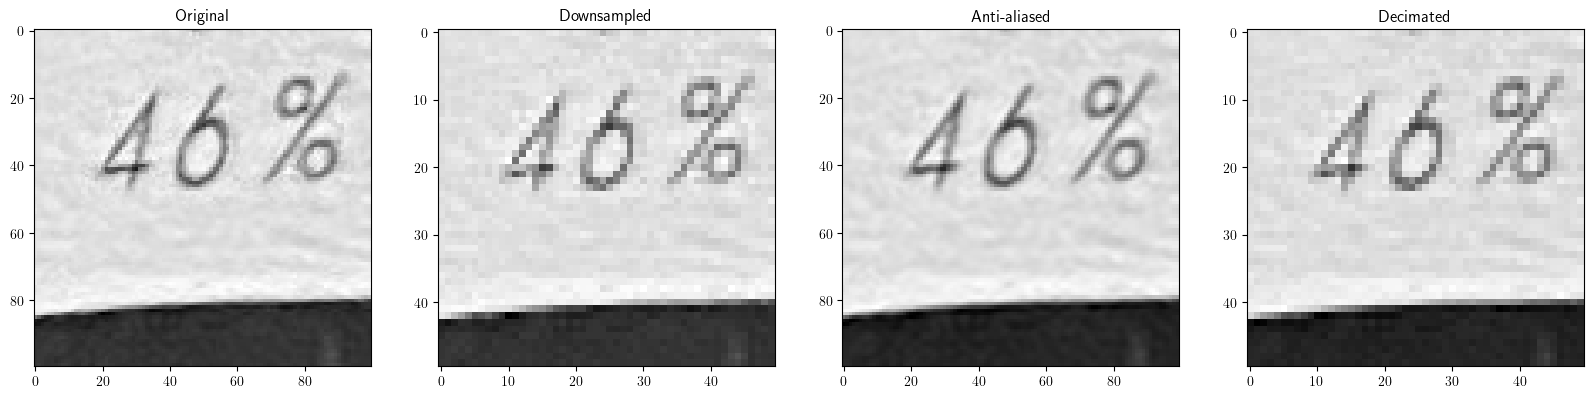

In [58]:
kernel,n = GetAntialiasingKernel('JPEG2000')
#kernel,n = GetAntialiasingKernel('Hamming Sinc')
kernel = kernel.reshape(-1,1) # Convert to matrix
kernel = np.matmul(kernel,np.transpose(kernel)) # Make into a 2D Kernel

for cImage in range(5):
    if cImage==0:
        image = GetImpulseImage(nPixelsPerSide=7)
    elif cImage==1:
        image = GetTestImage(nPixelsPerSide=31)
    elif cImage==2:
        image = GetChirpImage(nPixelsPerSide=51)        
    elif cImage==3:
        image = cv.imread('images/DarkTree.jpeg',cv.IMREAD_GRAYSCALE)
        image = image[150:220,150:220]
    else:
        image = cv.imread('images/Bourbon.jpeg',cv.IMREAD_GRAYSCALE)
        image = image[1100:1200,730:830]
    downsampled = image[::2,::2]
    antialiased = cv.filter2D(image,cv.CV_32F,kernel)
    decimated   = antialiased[::2,::2]
        
    figure = plt.figure()
    figure.set_size_inches(20,7)
    figure.clf()
    
    axes = figure.add_subplot(1,4,1)
    axes.imshow(image,cmap='gray')
    axes.set_title('Original')

    axes = figure.add_subplot(1,4,2)
    axes.imshow(downsampled,cmap='gray')
    axes.set_title('Downsampled')
    
    axes = figure.add_subplot(1,4,3)
    axes.imshow(antialiased,cmap='gray')
    axes.set_title('Anti-aliased')
    
    axes = figure.add_subplot(1,4,4)
    axes.imshow(decimated,cmap='gray')
    axes.set_title('Decimated')

    plt.show()

In [59]:
def DownsampleImage(image,kernelName='JPEG2000'):
    # Only downsamples by 2 - no other downsample rates supported
    kernel,n = GetAntialiasingKernel(kernelName)
    kernel = kernel.reshape(-1,1) # Convert to matrix
    kernel = np.matmul(kernel,np.transpose(kernel)) # Make into a 2D Kernel

    antialiased = cv.filter2D(image.astype('float32'),cv.CV_32F,kernel)
    decimated   = antialiased[::2,::2]
    
    return(decimated)

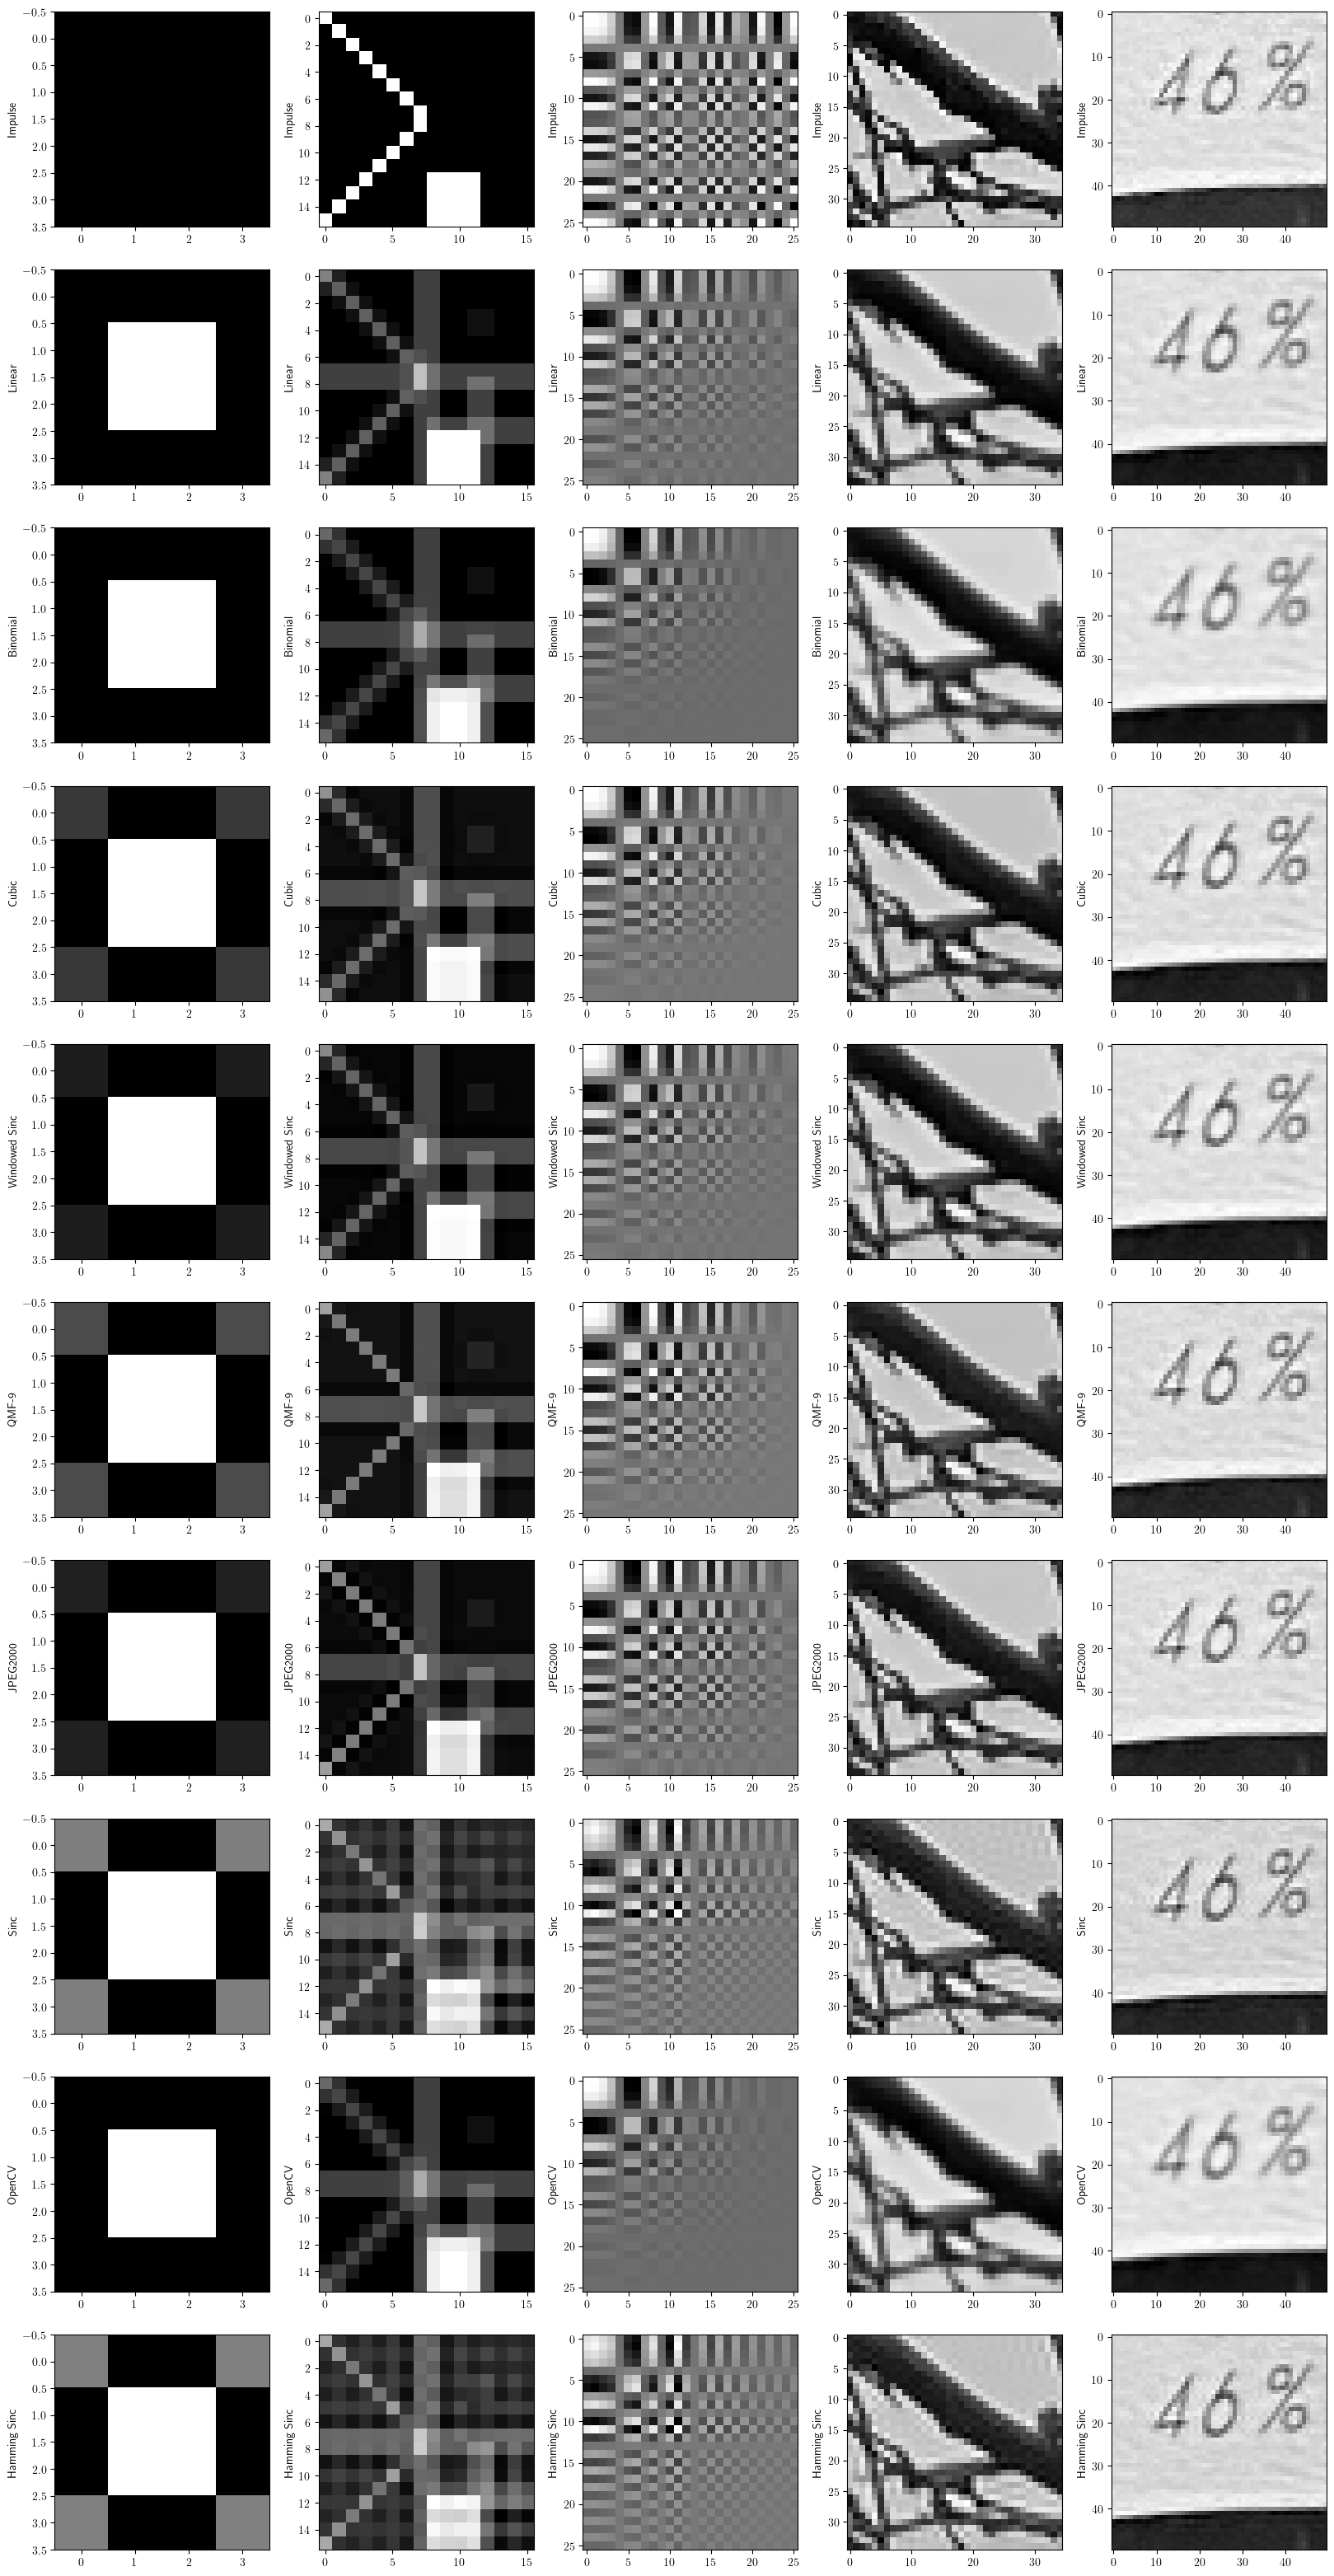

In [60]:
kernelNames = GetAntialiasingKernel()
nKernels = len(kernelNames)

nImages = 5

figure = plt.figure()
figure.set_size_inches(20,40)
figure.clf()

for cKernel,kernelName in enumerate(kernelNames):
    for cImage in range(nImages):
        if cImage==0:
            image = GetImpulseImage(nPixelsPerSide=7)
        elif cImage==1:
            image = GetTestImage(nPixelsPerSide=31)
        elif cImage==2:
            image = GetChirpImage(nPixelsPerSide=51)        
        elif cImage==3:
            image = cv.imread('images/DarkTree.jpeg',cv.IMREAD_GRAYSCALE)
            image = image[150:220,150:220]
        else:
            image = cv.imread('images/Bourbon.jpeg',cv.IMREAD_GRAYSCALE)
            image = image[1100:1200,730:830]

        image = image.astype('float')
        decimatedJM = DownsampleImage(image,kernelName=kernelName)

        axes = figure.add_subplot(nKernels,nImages,cKernel*nImages+cImage+1)
        axes.imshow(decimatedJM,cmap='gray')
        axes.set_ylabel(kernelName)

plt.show()

### OpenCV pyrDown

* OpenCV uses a function called pyrDown (pyramid downsample)
* How well does it perform
* What kernel does it use?
    * The same kernel it uses for interpolation!
* The OpenCV Documentation calls this "Gaussian"
\begin{equation*}
    \frac{1}{256}
    \begin{bmatrix}
    1 &  4 &  6 &  4 & 1\\
    4 & 16 & 24 & 16 & 4\\
    6 & 24 & 36 & 24 & 6\\
    4 & 16 & 24 & 16 & 4\\
    1 &  4 &  6 &  4 & 1\\
    \end{bmatrix}
    \hspace{100em}
\end{equation*}
* This is based on a binomial kernel that is simply 
\begin{equation*}
    \frac{1}{16} \begin{bmatrix} 1 & 4 & 6 & 4 & 1 \end{bmatrix}
    \hspace{100em}
\end{equation*}
* Apparently this is called "Gaussian" because if you apply this repeatedly, it eventually becomes Gaussian
    * But so does almost everything under repeated convolution

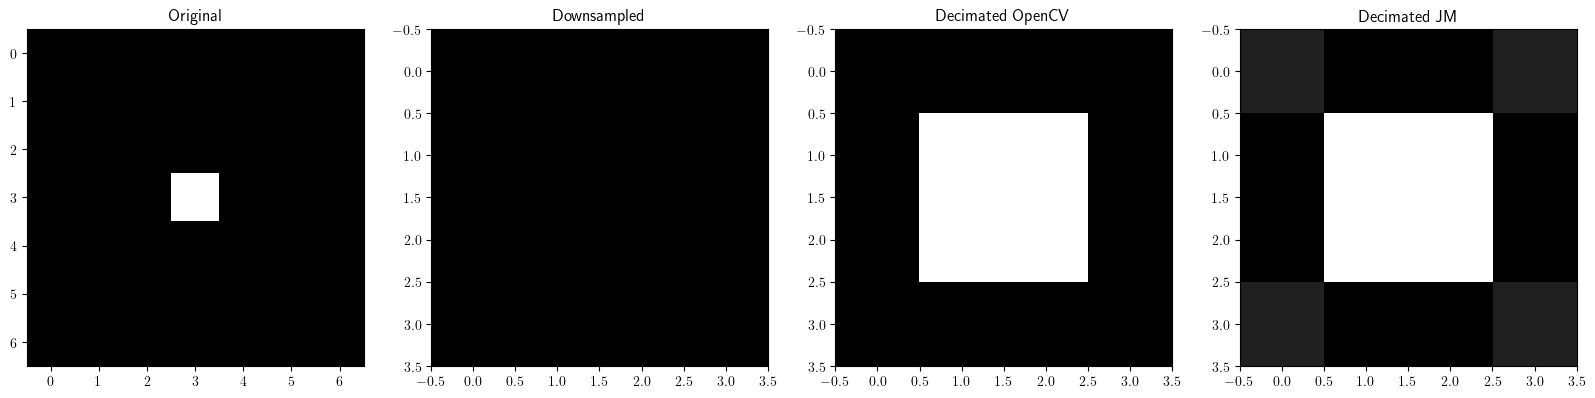

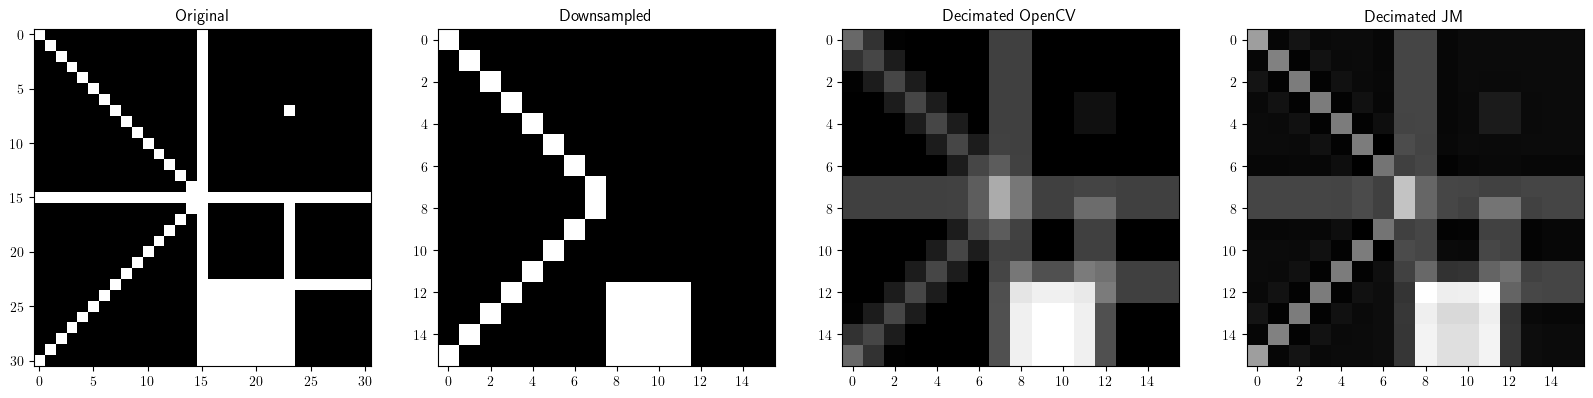

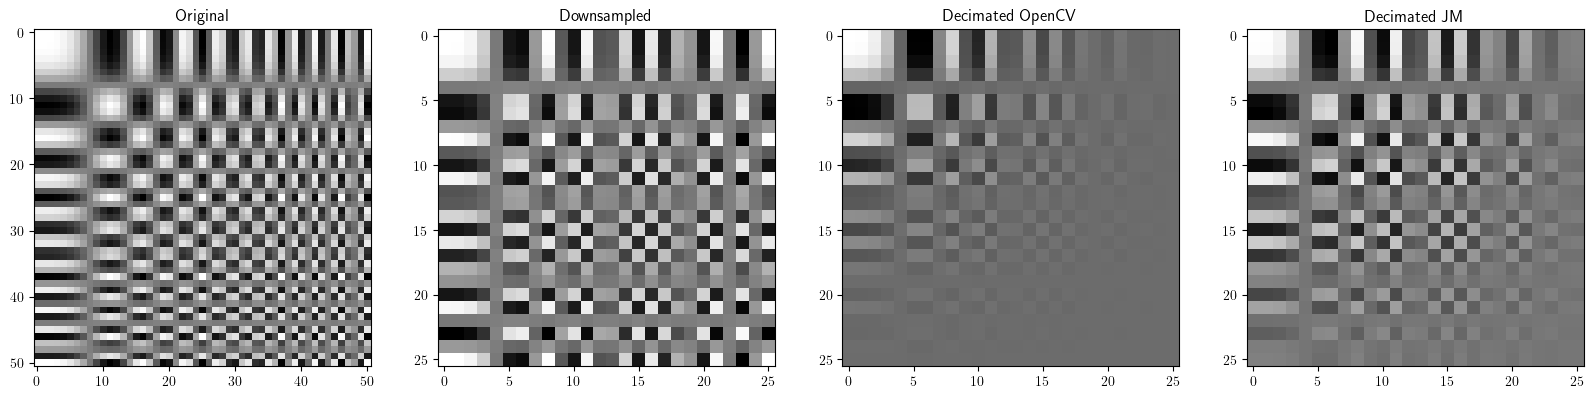

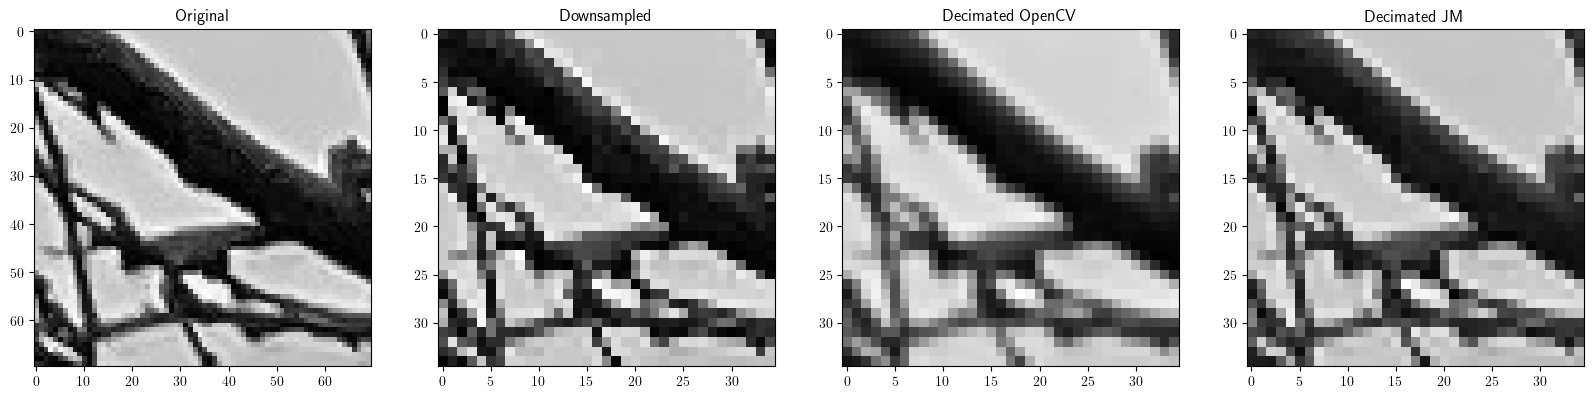

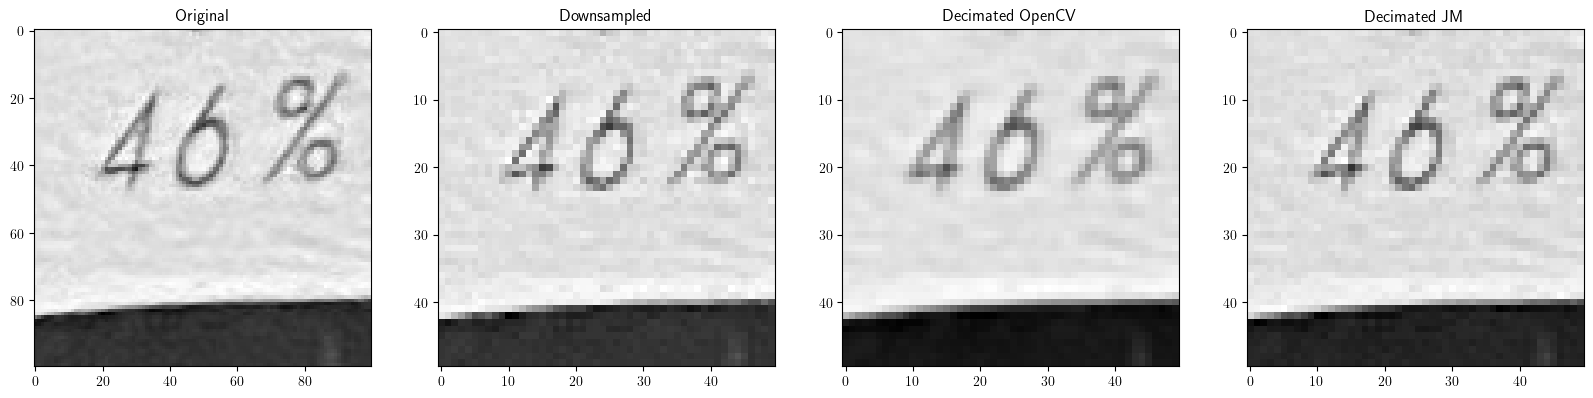

In [61]:
kernelName = 'JPEG2000'
#kernelName = 'OpenCV'

nImages = 5
for cImage in range(nImages):
    if cImage==0:
        image = GetImpulseImage(nPixelsPerSide=7)
    elif cImage==1:
        image = GetTestImage(nPixelsPerSide=31)
    elif cImage==2:
        image = GetChirpImage(nPixelsPerSide=51)        
    elif cImage==3:
        image = cv.imread('images/DarkTree.jpeg',cv.IMREAD_GRAYSCALE)
        image = image[150:220,150:220]
    else:
        image = cv.imread('images/Bourbon.jpeg',cv.IMREAD_GRAYSCALE)
        image = image[1100:1200,730:830]

    downsampled = image[::2,::2]
    decimatedCV = cv.pyrDown(image)
    decimatedJM = DownsampleImage(image,kernelName=kernelName)
        
    figure = plt.figure()
    figure.set_size_inches(20,7)
    figure.clf()
    
    axes = figure.add_subplot(1,4,1)
    axes.imshow(image,cmap='gray')
    axes.set_title('Original')

    axes = figure.add_subplot(1,4,2)
    axes.imshow(downsampled,cmap='gray')
    axes.set_title('Downsampled')
    
    axes = figure.add_subplot(1,4,3)
    axes.imshow(decimatedCV,cmap='gray')
    axes.set_title('Decimated OpenCV')
    
    axes = figure.add_subplot(1,4,4)
    axes.imshow(decimatedJM,cmap='gray')
    axes.set_title('Decimated JM')

    plt.show()

### pyrDown Observations

* The kernel is the same as the kernel used for pyrUp!
* Not nearly as much of a difference as compared to interpolation
* Flat regions are not much of a problem
* pyrDown smooths more than the kernels that are used most frequently

# Image Pyramids

* In practice, elements of images can occur at a variety of scales
* Our algorithms need to be able to work at all these different scales
* Imagine a photo with an object that is far away, and another image in which the object occupies the entire frame
* Since these are both of the same object, but they are at very different resolutions, how do we compare them?
* Note that we can also save a lot of computation by working at lower resolutions
    * Important to evaluate the tradeoff between computation and accuracy


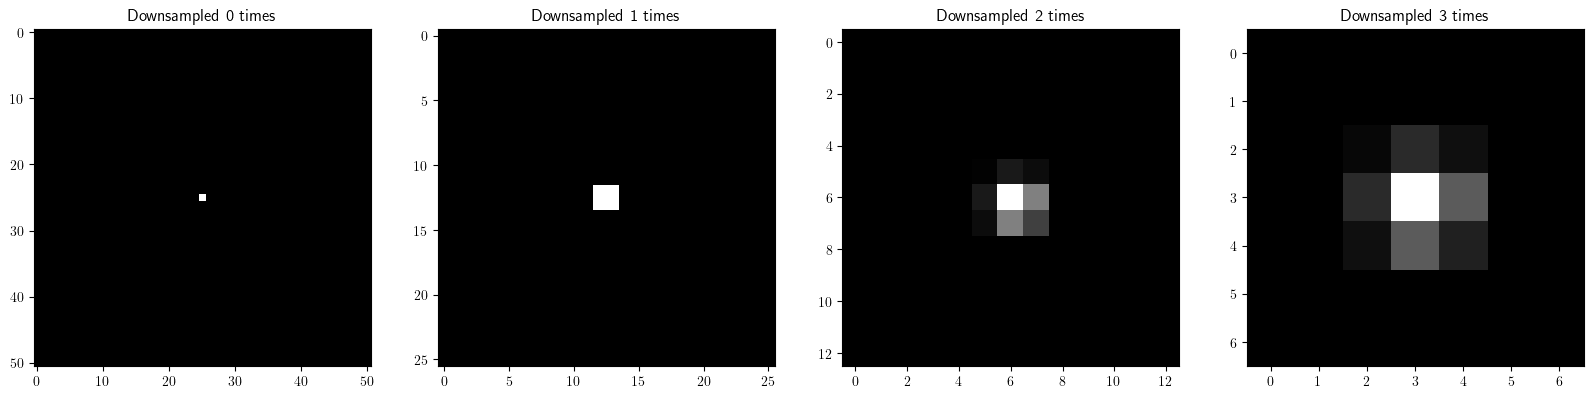

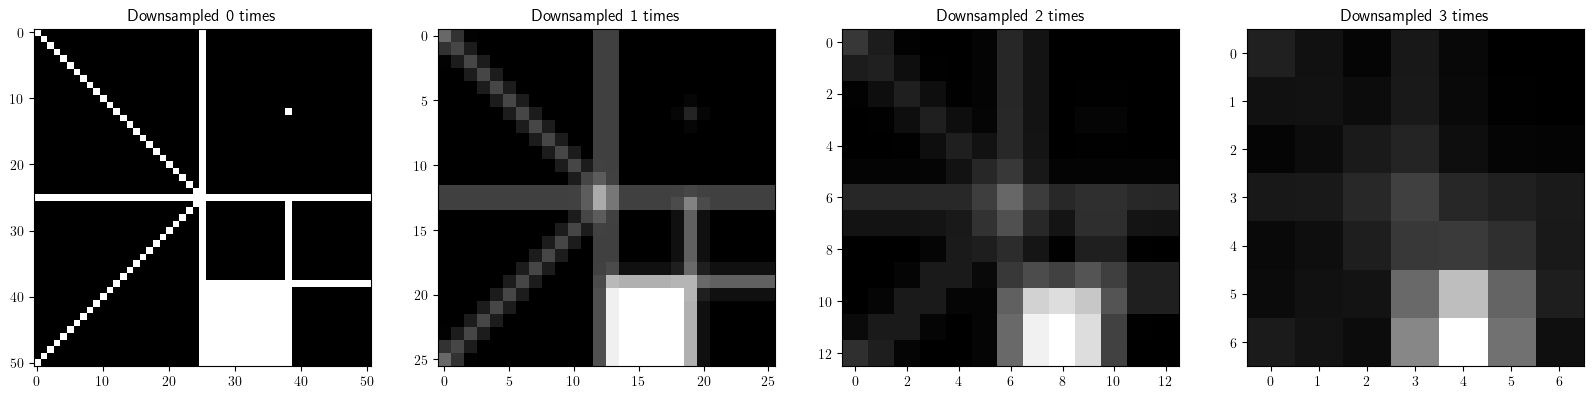

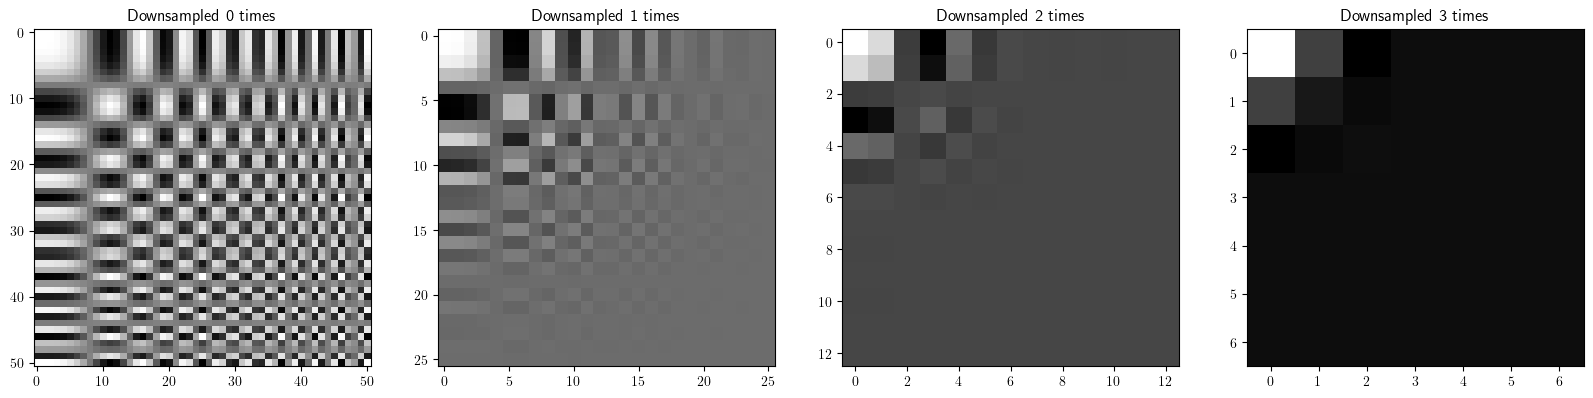

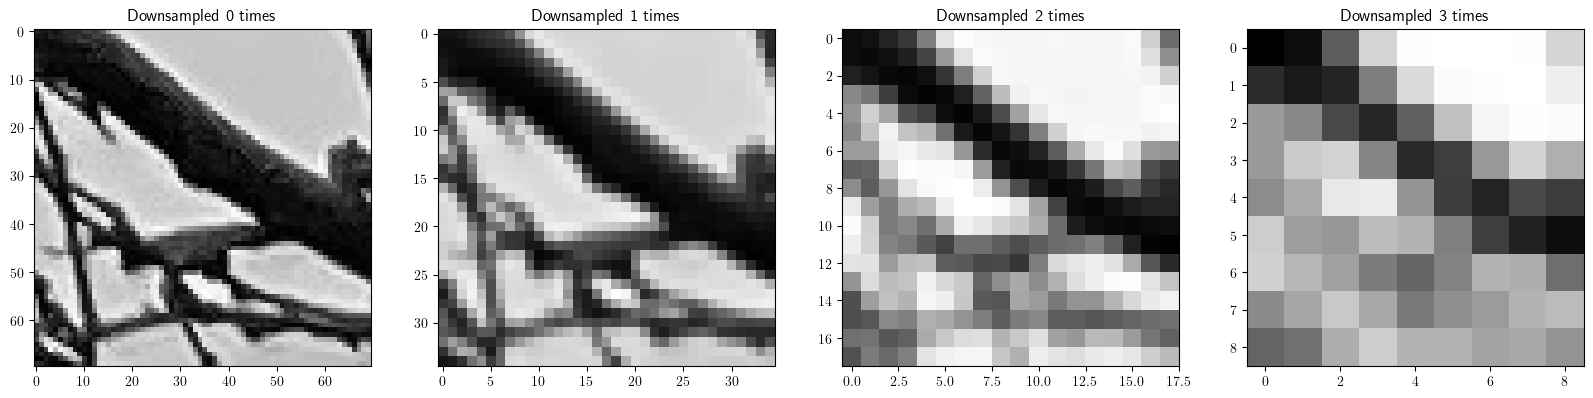

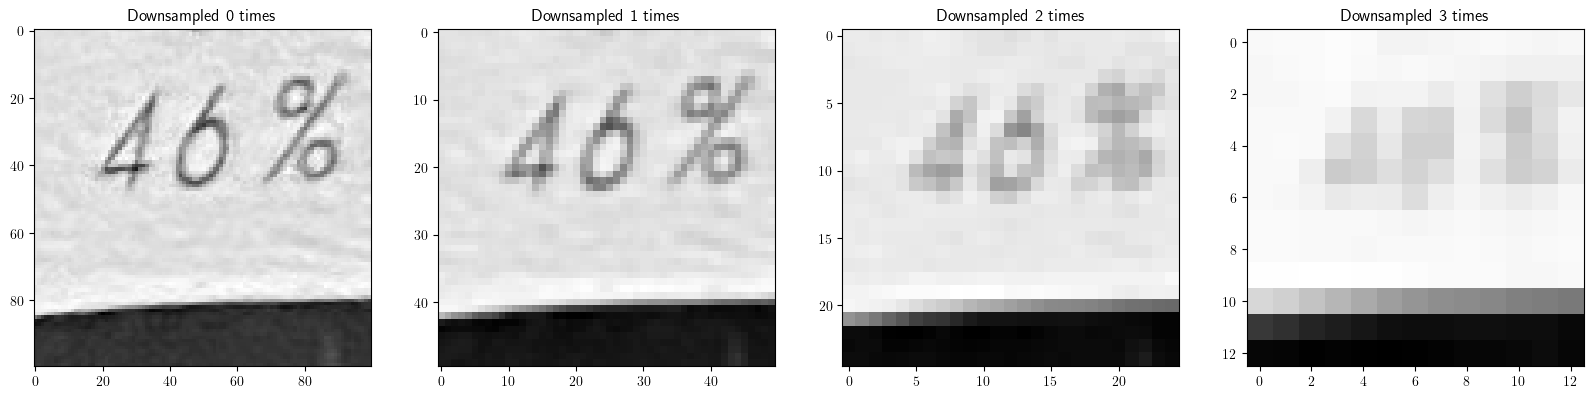

In [62]:
nImages = 5
for cImage in range(nImages):
    if cImage==0:
        image = GetImpulseImage(nPixelsPerSide=51)
    elif cImage==1:
        image = GetTestImage(nPixelsPerSide=51)
    elif cImage==2:
        image = GetChirpImage(nPixelsPerSide=51)        
    elif cImage==3:
        image = cv.imread('images/DarkTree.jpeg',cv.IMREAD_GRAYSCALE)
        image = image[150:220,150:220]
    else:
        image = cv.imread('images/Bourbon.jpeg',cv.IMREAD_GRAYSCALE)
        image = image[1100:1200,730:830]
        
    figure = plt.figure()
    figure.set_size_inches(20,5)
    figure.clf()
    
    for cDownsample in range(4):
        axes = figure.add_subplot(1,4,cDownsample+1)
        axes.imshow(image,cmap='gray')
        axes.set_title('Downsampled %d times' % (cDownsample))
        #image = DownsampleImage(image,kernelName=kernelName)
        image = cv.pyrDown(image)
    
    plt.show()

### Up and Down in Scale

* Of course, we can upsample downsampled images
* We can go up and down in scale


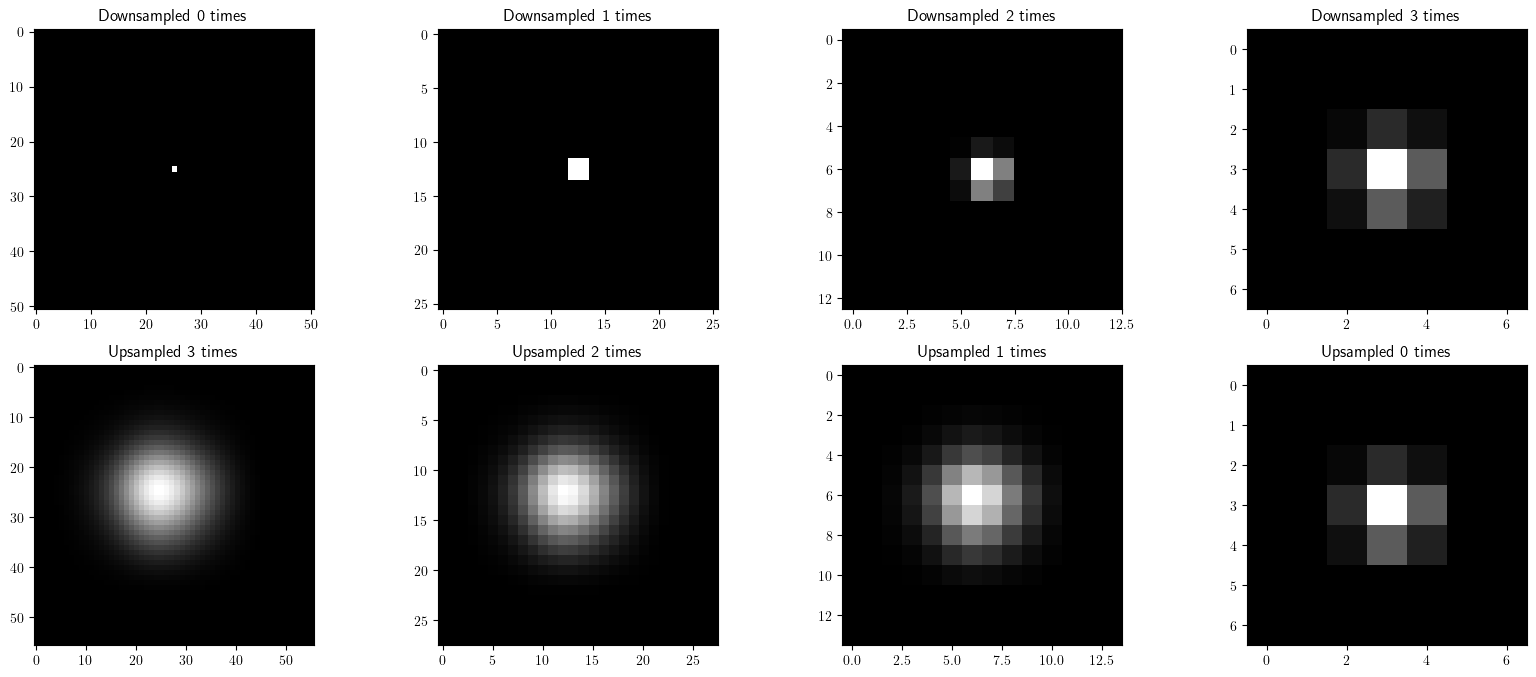

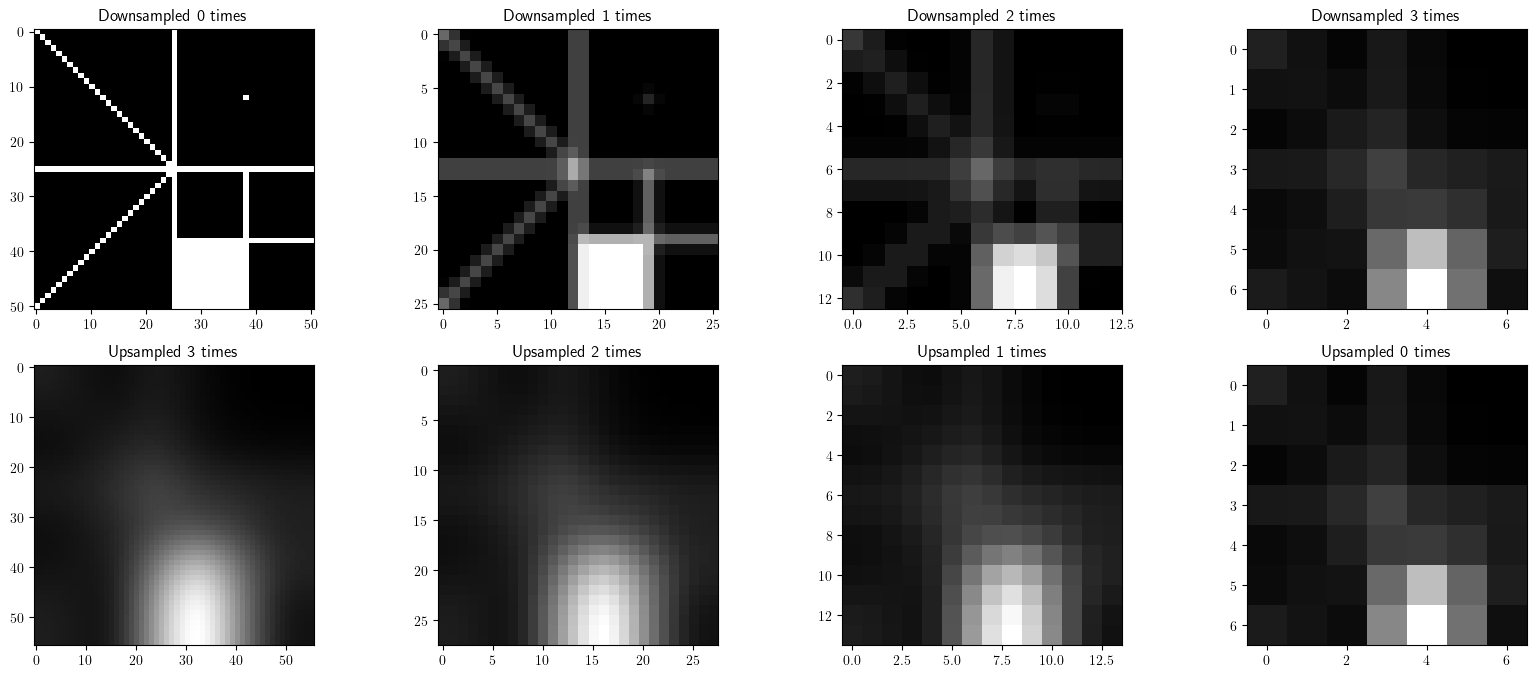

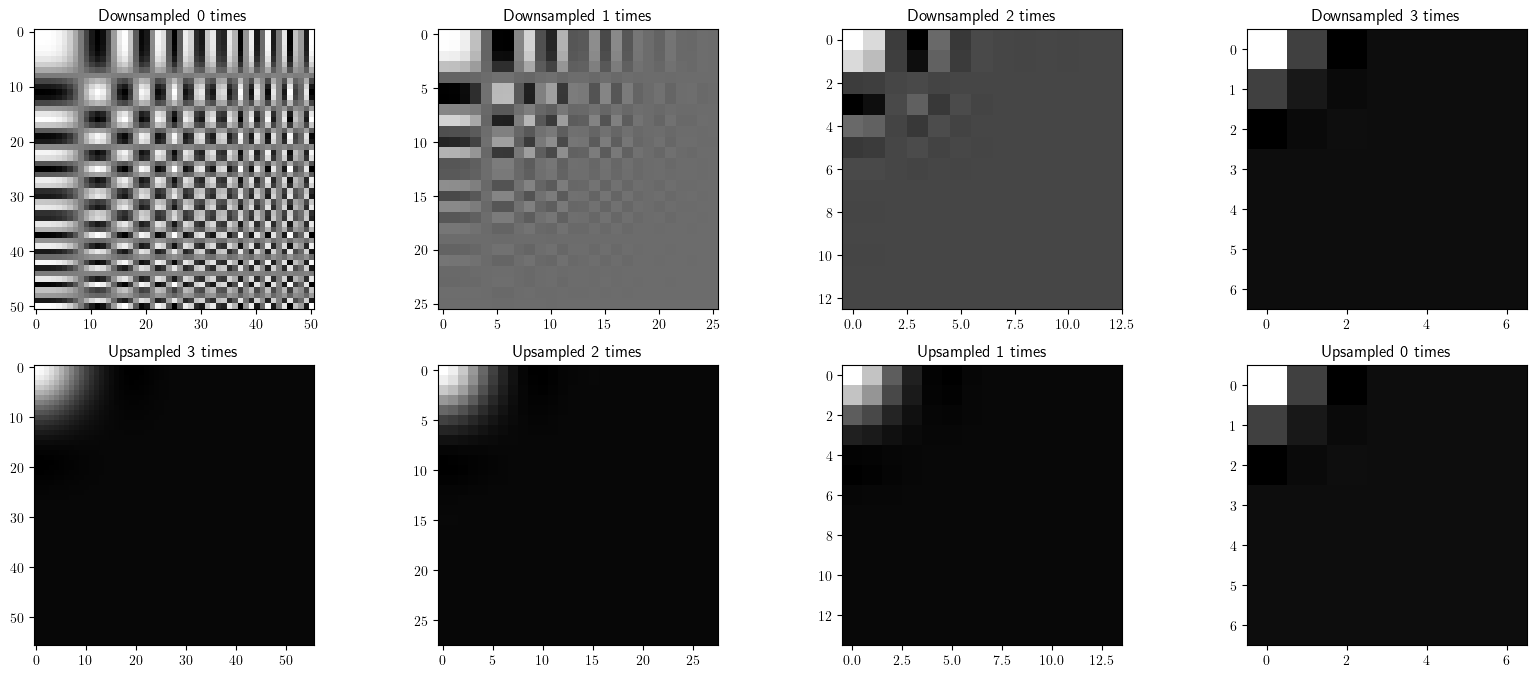

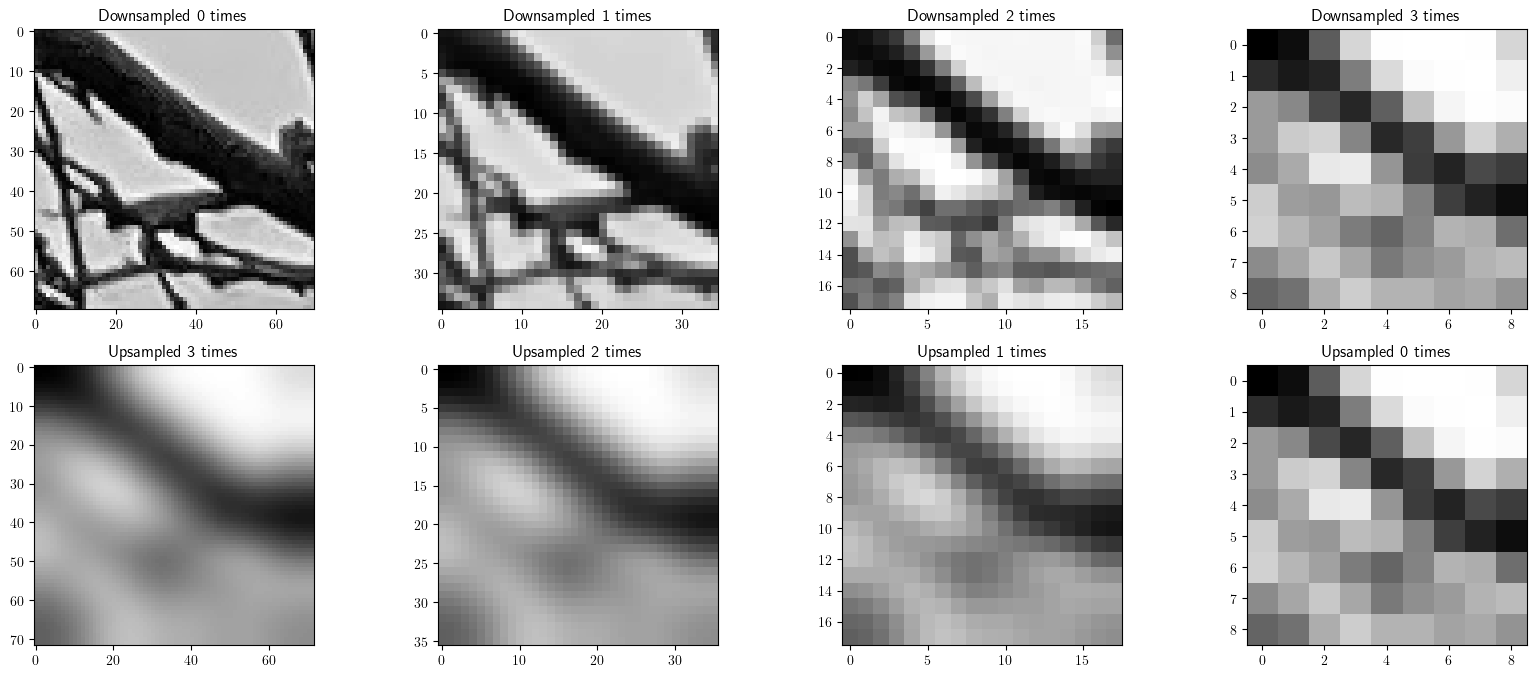

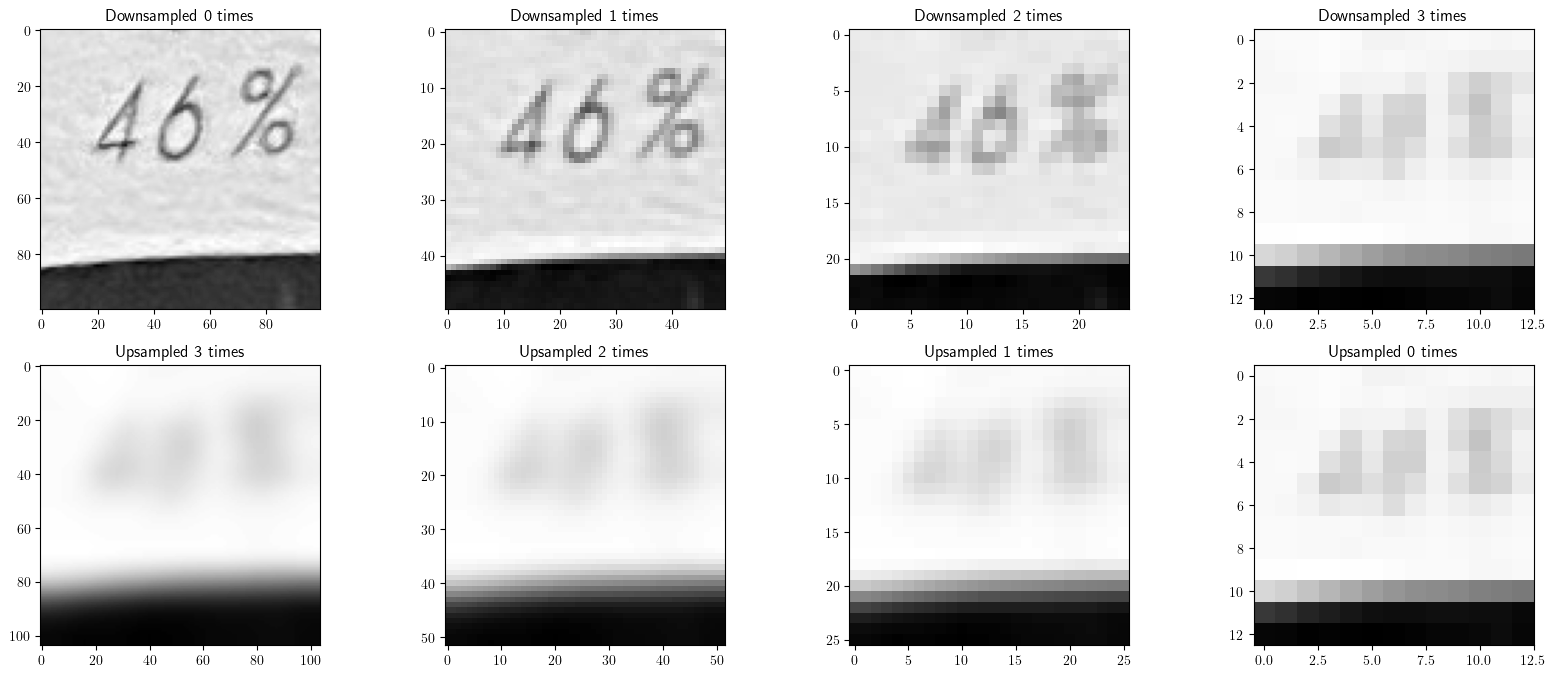

In [66]:
nImages = 5
for cImage in range(nImages):
    if cImage==0:
        image = GetImpulseImage(nPixelsPerSide=51)
    elif cImage==1:
        image = GetTestImage(nPixelsPerSide=51)
    elif cImage==2:
        image = GetChirpImage(nPixelsPerSide=51)        
    elif cImage==3:
        image = cv.imread('images/DarkTree.jpeg',cv.IMREAD_GRAYSCALE)
        image = image[150:220,150:220]
    else:
        image = cv.imread('images/Bourbon.jpeg',cv.IMREAD_GRAYSCALE)
        image = image[1100:1200,730:830] 
           
    figure = plt.figure()
    figure.set_size_inches(20,8)
    figure.clf()
    
    for cDownsample in range(4):
        axes = figure.add_subplot(2,4,cDownsample+1)
        axes.imshow(image,cmap='gray')
        axes.set_title('Downsampled %d times' % (cDownsample))
        if cDownsample==3:
            break
        image = cv.pyrDown(image) # Anti-aliases & decimates
        #image = image[::2,::2] # Try this to see the importance of the antialiasing filter
        
    for cUpsample in range(4):
        axes = figure.add_subplot(2,4,4+(3-cUpsample)+1)
        axes.imshow(image,cmap='gray')
        axes.set_title('Upsampled %d times' % (cUpsample))
        image = cv.pyrUp(image,2) 
            
    plt.show()

### Laplacian Pyramids

* Its desirable in constructing a pyramid to be able to perfectly reconstruct the image
* These pyramids are sometimes called _self inverting_
* One way to do this is to calculate a residual and save it 
* Similar in principle to a difference of Gaussians
* Note that its actually a misnomer to called these pyramids Laplacian, since they are actually differences of approximate Gaussians
* But as with many ideas in computer vision, its close enough



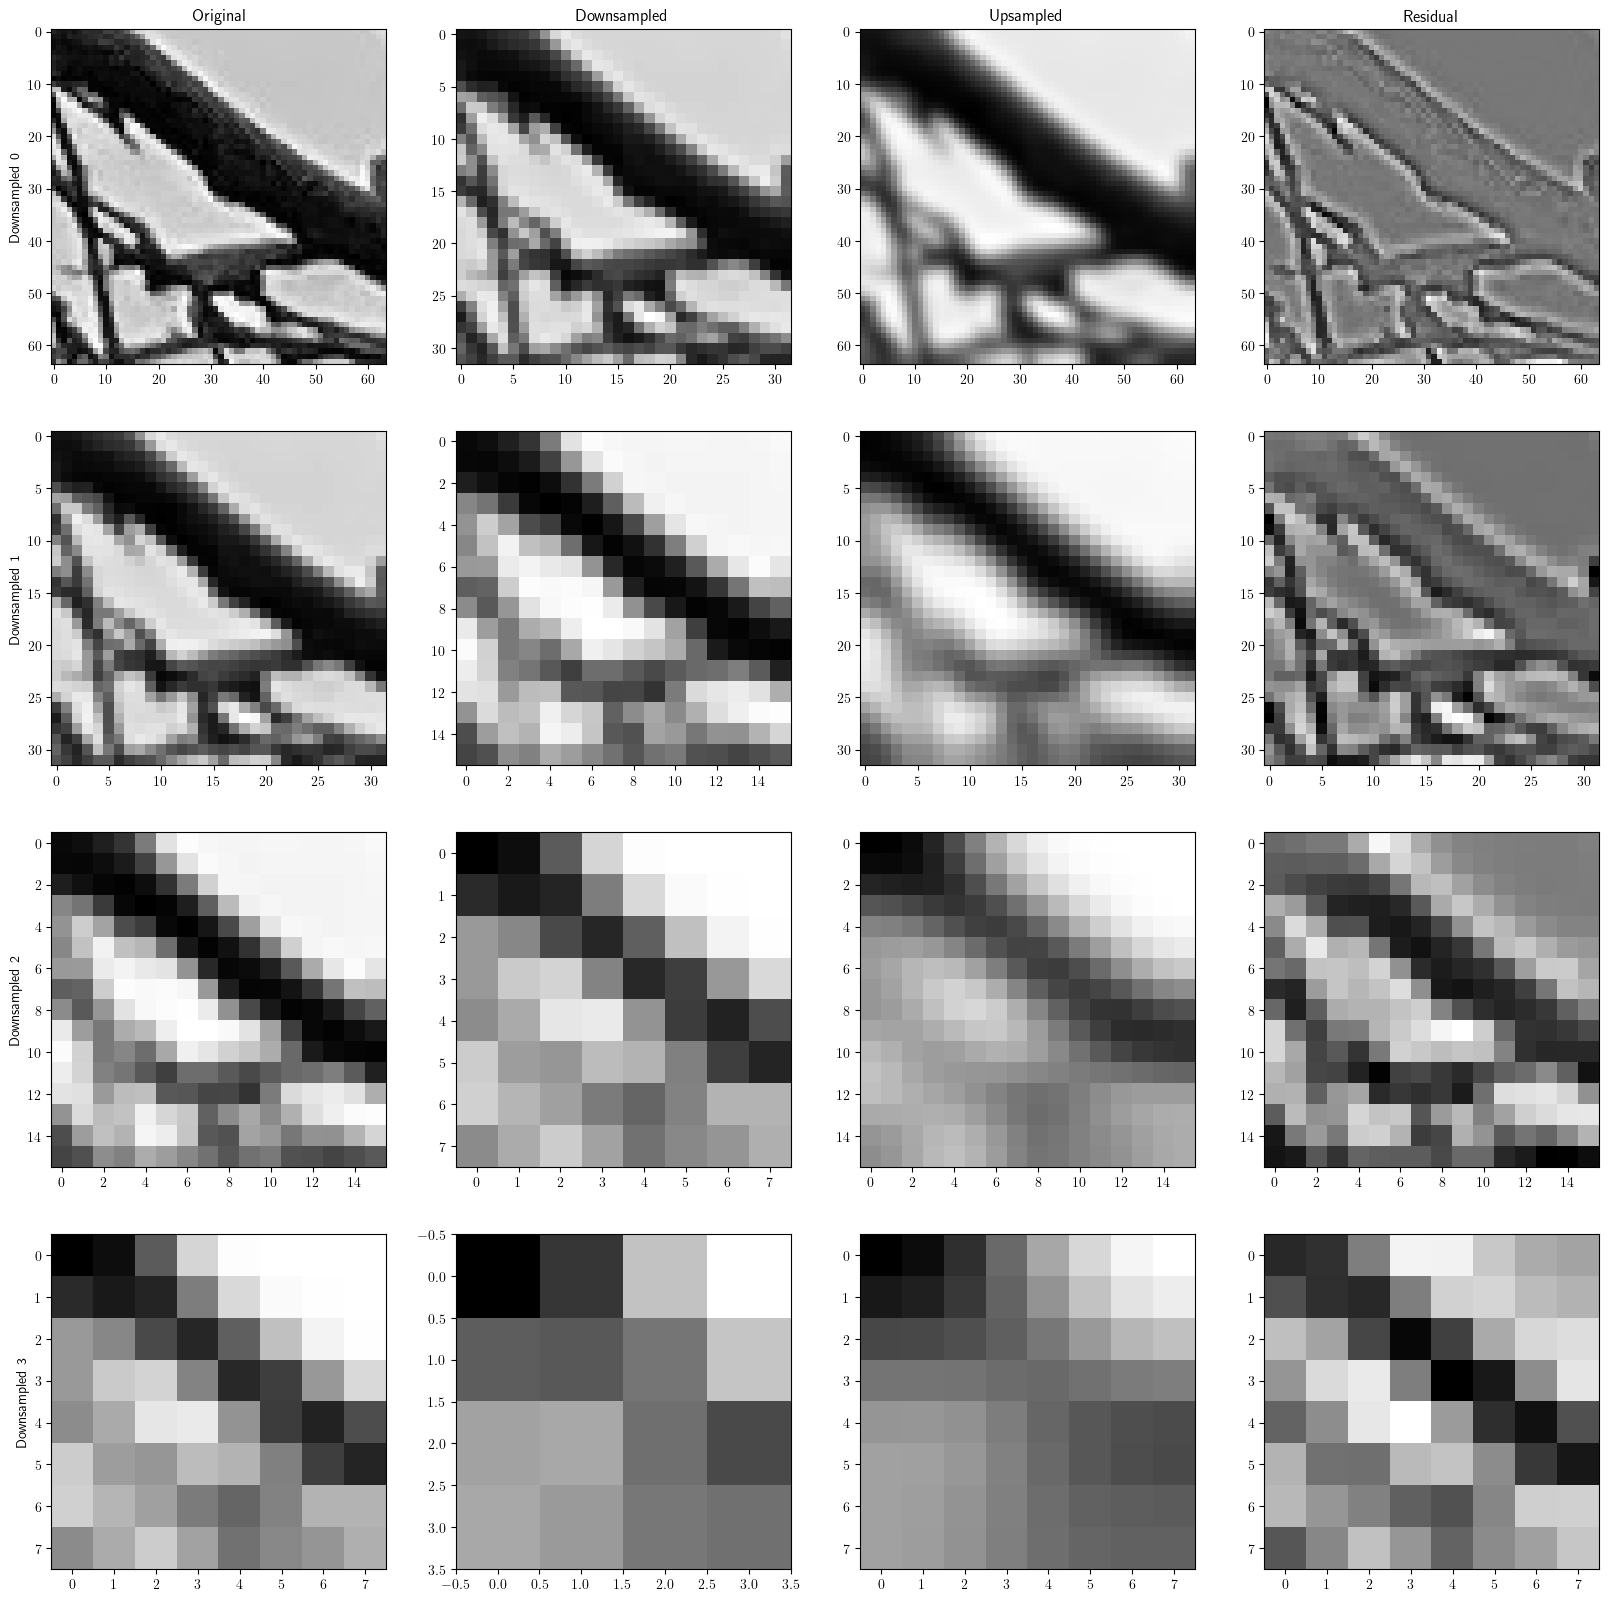

In [64]:
images = range(nImages)
images = [3]

nImages = len(images)

for cImage in images:
    if cImage==0:
        image = GetImpulseImage(nPixelsPerSide=2**6)
    elif cImage==1:
        image = GetTestImage(nPixelsPerSide=2**6)
    elif cImage==2:
        image = GetChirpImage(nPixelsPerSide=2**6)        
    else:
        image = cv.imread('images/DarkTree.jpeg',cv.IMREAD_GRAYSCALE)
        image = image[150:(150+2**6),150:(150+2**6)]

    figure = plt.figure()
    figure.set_size_inches(20,20)
    figure.clf()

    image = image.astype('float32')
    
    for cDownsample in range(4):
        downsampled = cv.pyrDown(image)
        upsampled   = cv.pyrUp(downsampled)
        residual    = image - upsampled
        
        axes = figure.add_subplot(4,4,cDownsample*4+1)
        axes.imshow(image,cmap='gray')
        axes.set_ylabel('Downsampled %d' % cDownsample)
        if cDownsample==0:
            axes.set_title('Original')
        
        axes = figure.add_subplot(4,4,cDownsample*4+2)
        axes.imshow(downsampled,cmap='gray') 
        if cDownsample==0:
            axes.set_title('Downsampled')
        
        axes = figure.add_subplot(4,4,cDownsample*4+3)
        axes.imshow(upsampled,cmap='gray')
        if cDownsample==0:
            axes.set_title('Upsampled')
        
        axes = figure.add_subplot(4,4,cDownsample*4+4)
        axes.imshow(residual,cmap='gray')
        if cDownsample==0:
            axes.set_title('Residual')        
        
        image = downsampled
            
    plt.show()

### Image Pyramid Extensions

* Pyramids with levels separated by a full downsample factor of 2 are sometimes called _octave pyramids_
* It is possible to instead do multiple degrees of smoothing before getting to the point where you can decimate by a factor of 2
* For example, if using a Gaussian (or approximation), the standard deviation could be increased at each level by $\sqrt{2}$
* These are called _half octave_ pyramids
    * Also called difference of low-pass (DOLP) transforms
* There are also variations that sample with a checkerboard pattern, rather than a grid
    * Called _quincunx sampling_
* It is also possible to do this with wavelets
* As mentioned previously, the degree of smoothing (and decimating to save computation, if you like), can be thought of as the scale of the image
    * High-frequency features are removed
    * Smooth features are retained
* This is like looking at the image in another dimension (roughly analagous to the amount of zoom)
* Thus, we can think of images as having three continuous dimensions
    * Two spatial coordinates (again, think of as a surface, rather than a collection of pixels)
    * Perhaps a color coordinate (discrete, and categorical, though)
    * Spatial dimension
* If we add video, this takes us into 5 dimensions with the fifth dimension being time

